In [60]:
import datajoint as dj
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import behav_viz.utils.plot_utils as pu

dj.blob.use_32bit_dims = True  # not using blob columns
sns.set_context("talk")

## 1. Load Data

Loading any animal that was trained on PWM since I joined the lab (can either be rat or mouse)

In [2]:
bdata = dj.create_virtual_module("bdata", "bdata")
ratinfo = dj.create_virtual_module("intfo", "ratinfo")

In [3]:
print(bdata.Sessions.describe())

# data from all rat sessions
sessid               : int                          
---
ratname=""           : varchar(30)                  
hostname=""          : varchar(30)                  
experimenter=""      : varchar(30)                  
starttime="00:00:00" : time                         
endtime="00:00:00"   : time                         
sessiondate="0000-00-00" : date                         
n_done_trials=0      : int                          
comments=null        : varchar(1000)                
settings_file=""     : varchar(200)                 
settings_path=""     : varchar(200)                 
data_file=""         : varchar(200)                 
data_path=""         : varchar(200)                 
video_file=""        : varchar(200)                 
video_path=""        : varchar(200)                 
protocol=""          : varchar(30)                  
total_correct=null   : float(2,2)                   
right_correct=null   : float(2,2)                   
left_corr

In [37]:
key = {"protocol": "PWM"}
cpoke_df = pd.DataFrame(
    (bdata.Sessions & key & 'sessiondate > "2021-05-01"').fetch(as_dict=True)
)

## 1.2 Clean Data

In [38]:
experimenters = cpoke_df.experimenter.unique()
animals = cpoke_df.ratname.unique()
print(f"Experimenters: {experimenters}")
print(f"Animals: {animals}")

Experimenters: ['Jess' 'Emily' 'Josh' 'Jorge']
Animals: ['R001' 'R002' 'R004' 'R003' 'E161' 'E159' 'E160' 'D083' 'D084' 'D094'
 'D093' 'D099' 'D100' 'E138' 'E164' 'E166' 'E167' 'E169' 'E168' 'E171'
 'E170' 'D104' 'D103' 'D102' 'D101' 'E165' 'I002' 'E173' 'E174' 'E175'
 'E172' 'I003' 'Y003' 'Y004' 'Y001' 'Y002' 'Y005' 'Y006' 'Y008' 'Y007']


In [158]:
# Remove Josh since these are bpod testing animals
pwm_df = pwm_df.query("experimenter != 'Josh'").copy()

y_animals_pwm2 = ["Y005", "Y006", "Y007", "Y008"]  # PWM2 animals
pwm_df = pwm_df.query("ratname not in @y_animals_pwm2").copy()

# Mark species
pwm_df["species"] = "rat"
pwm_df.loc[pwm_df.ratname.str.contains("D"), "species"] = "mouse"

# drop animals with < 50 sessions
n_sessions_df = pwm_df.groupby("ratname").sessiondate.count().reset_index()
n_sessions_df.rename(columns={"sessiondate": "n_sessions"}, inplace=True)
valid_animals = n_sessions_df.query("n_sessions > 50").ratname.values
pwm_df = pwm_df.query("ratname in @valid_animals").copy()
pwm_df = pwm_df.query("n_done_trials > 1").copy()

[Text(0.5, 1.0, 'Number of sessions per animal'),
 Text(0.5, 0, 'Animal'),
 Text(0, 0.5, 'Number of sessions')]

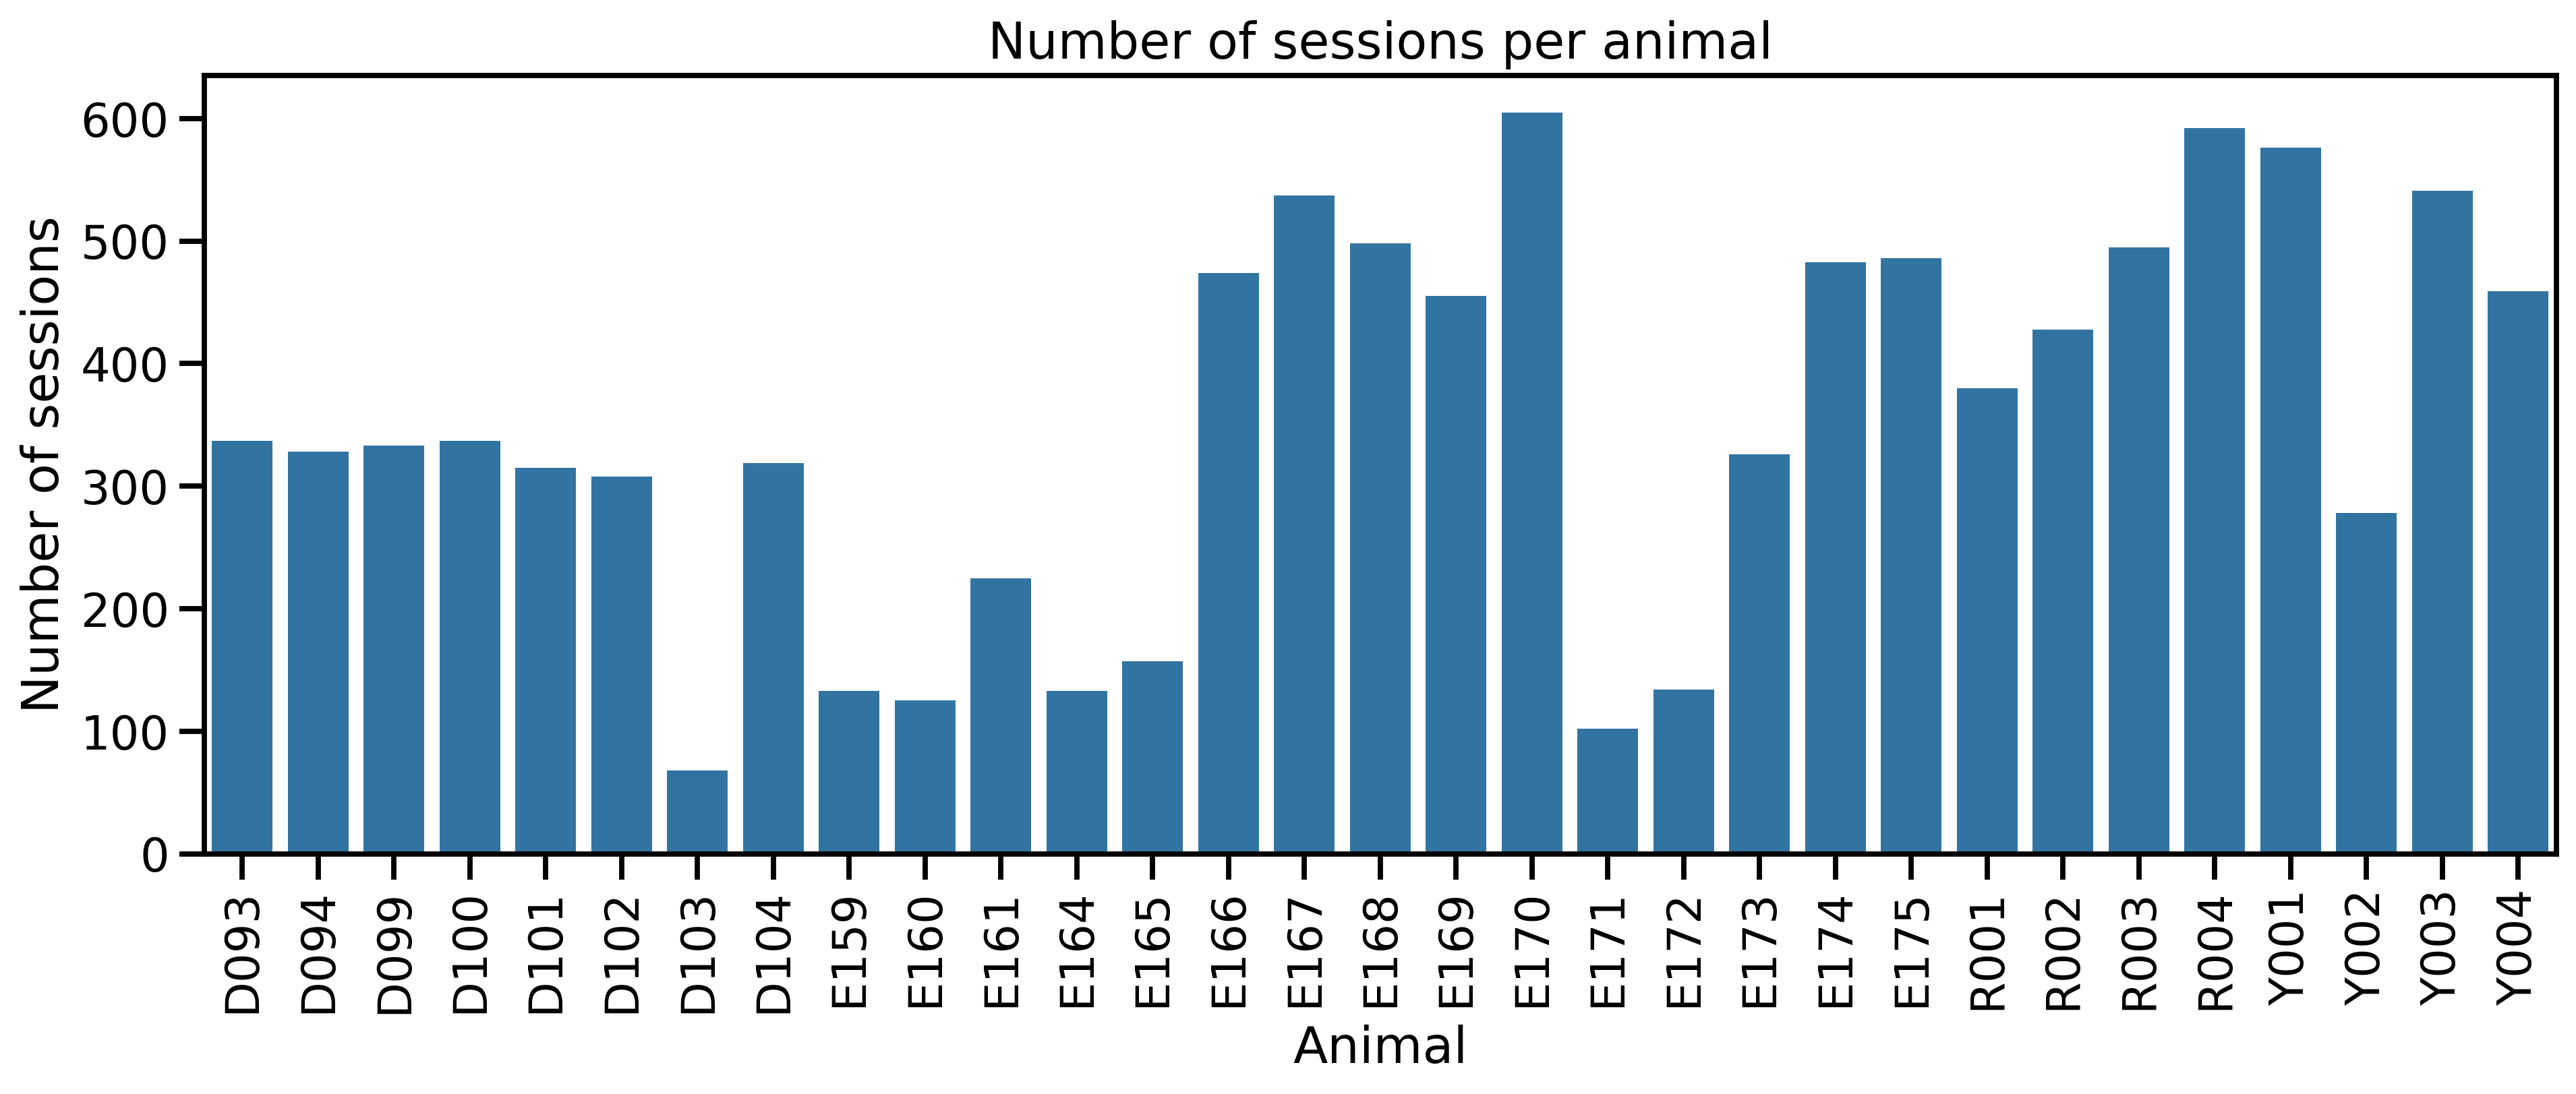

In [159]:
fig, ax = pu.make_fig((15, 5))
sns.barplot(
    n_sessions_df.query("ratname in @valid_animals"),
    x="ratname",
    y="n_sessions",
)

ax.tick_params(axis="x", rotation=90)
ax.set(
    title="Number of sessions per animal",
    xlabel="Animal",
    ylabel="Number of sessions",
)

## 1.3 Label Stages

In [160]:
pwm_df.comments

0        always, t= 11, v= 1.00, h= NaN\ndelta=6.9\n lo...
1        delayed, t= 48, v= 0.60, h= 0.58\ndelta=4.9\n ...
2        learning reward sounds, t= 861, v= 0.00, h= 1....
3        grow nose poke, t= 330, v= 0.20, h= 0.83\ndelt...
4        delayed, t= 90, v= 0.98, h= 0.50\ndelta=4.9\n ...
                               ...                        
11941    11 never, t= 157, v= 0.18, h= 0.66\ndelta=5.0\...
11942    11 never, t= 185, v= 0.11, h= 0.68\ndelta=5.0\...
11943    11 never, t= 124, v= 0.13, h= 0.65\ndelta=5.0\...
11944    11 never, t= 282, v= 0.20, h= 0.67\ndelta=5.0\...
11945    11 never, t= 172, v= 0.17, h= 0.78\ndelta=5.0\...
Name: comments, Length: 10967, dtype: object

In [161]:
def determine_stage(row):
    if "comments" not in row:
        return "unknown"

    comment = row["comments"]
    if isinstance(comment, str):
        if "grow" in comment.lower():
            return "gnp", 2
        elif "always" in comment.lower():
            return "always", 3
        elif "delayed" in comment.lower():
            return "delayed", 4
        elif "never" in comment.lower():
            return "never", 5
        elif "learning" in comment.lower():
            return "spoke", 1
        elif "error" in comment.lower() or "unable" in comment.lower():
            return "error", np.nan
    return "unknown", 0


pwm_df[["stage_name", "stage_number"]] = pwm_df.apply(
    determine_stage, axis=1, result_type="expand"
)
pwm_df.query("stage_name == 'unknown'").comments.unique()  # no unknown stages

array([], dtype=object)

In [162]:
pwm_df = pwm_df.query("n_done_trials > 1").copy()

## 2. Stage properties & yeild

<Axes: xlabel='sessiondate', ylabel='stage_number'>

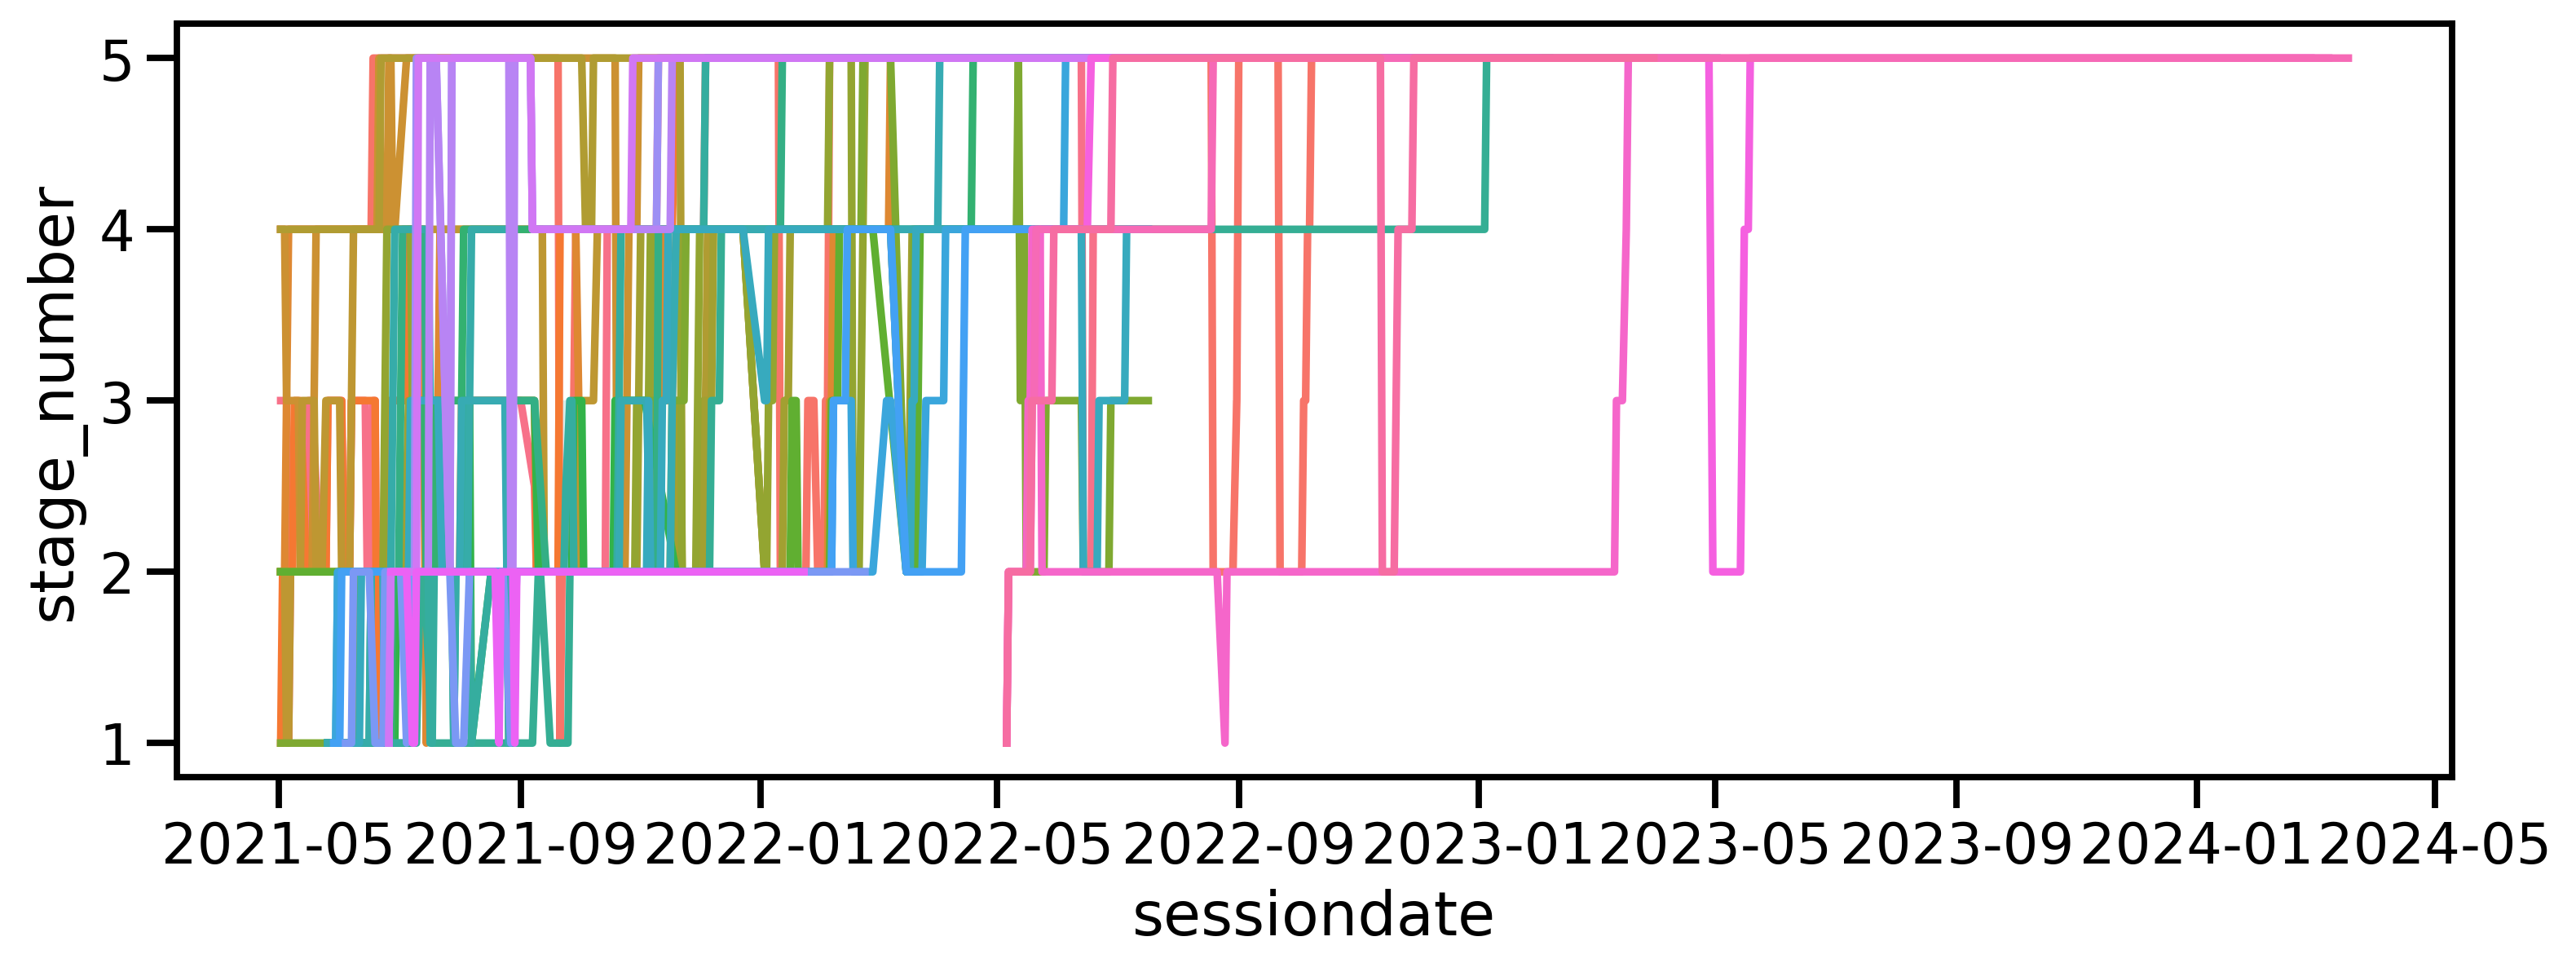

In [163]:
fig, ax = pu.make_fig()
sns.lineplot(
    data=pwm_df,
    x="sessiondate",
    y="stage_number",
    hue="ratname",
    legend=False,
)

In [164]:
# Get unique rat names for different categories
all_rats = set(pwm_df["ratname"].unique())
always_rats = set(pwm_df.query("stage_name == 'always'")["ratname"].unique())
delayed_rats = set(pwm_df.query("stage_name == 'delayed'")["ratname"].unique())
never_rats = set(pwm_df.query("stage_name == 'never'")["ratname"].unique())
gnp_rats = set(pwm_df.query("stage_name == 'gnp'")["ratname"].unique())

# Find rats not in 'never' stage but in all rats
not_never_rats = all_rats - never_rats
pwm_df["not_sound_rule"] = pwm_df.ratname.isin(not_never_rats)

in_delayed_not_always = delayed_rats - always_rats
# Find rats not in 'gnp' stage but in all rats
not_gnp_rats = all_rats - gnp_rats

### 2.1 Stage Yields 

Note this says nothing about the performance of the animal in the stage, just if they made it. Dropping always and spoke stages as they are not consistently encoded for all animals.

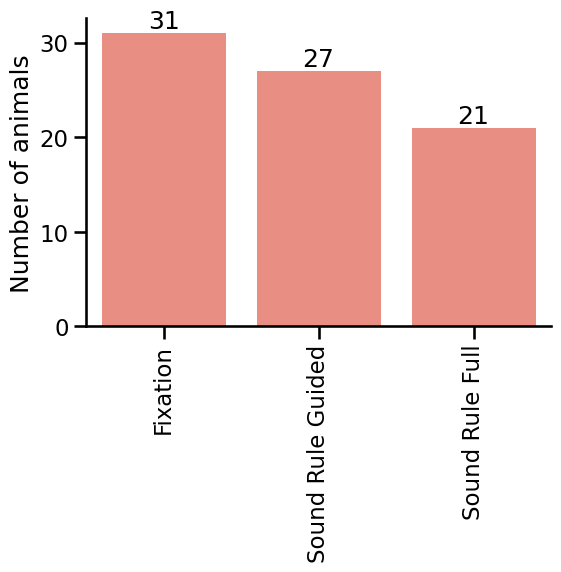

In [274]:
stage_counts = (
    pwm_df.groupby("stage_number")["ratname"].nunique().sort_index().reset_index()
)

stage_counts["stage_name"] = stage_counts["stage_number"].map(
    {
        1.0: "spoke",
        2.0: "Fixation",
        3.0: "Sound Rule 0",
        4.0: "Sound Rule Guided",
        5.0: "Sound Rule Full",
    }
)

# fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=stage_counts.query("stage_number > 1 and stage_number !=3"),
    x="stage_name",
    y="ratname",
    ax=ax,
    color="salmon",
)

# put counts on top of bars
for i, row in (
    stage_counts.query("stage_number > 1 and stage_number !=3").reset_index().iterrows()
):
    ax.text(
        i,
        row["ratname"],
        row["ratname"],
        ha="center",
        va="bottom",
        color="black",
    )

ax.set(
    xlabel="",
    ylabel="Number of animals",
)
ax.tick_params(axis="x", rotation=90)

sns.despine()

### 2.2 Violation Rates for Animals that reached never vs not 

In [167]:
pwm_df.columns

Index(['sessid', 'ratname', 'hostname', 'experimenter', 'starttime', 'endtime',
       'sessiondate', 'n_done_trials', 'comments', 'settings_file',
       'settings_path', 'data_file', 'data_path', 'video_file', 'video_path',
       'protocol', 'total_correct', 'right_correct', 'left_correct',
       'percent_violations', 'brokenbits', 'protocol_data', 'left_pokes',
       'center_pokes', 'right_pokes', 'technotes', 'IP_addr', 'crashed',
       'foodpuck', 'species', 'stage_name', 'stage_number', 'not_never',
       'not_sound_rule'],
      dtype='object')

In [168]:
cpoke_df = pwm_df.query("stage_number > 1").copy()

In [174]:
cpoke_df.query("percent_violations == 0")

,sessid,ratname,hostname,experimenter,starttime,endtime,sessiondate,n_done_trials,comments,settings_file,...,right_pokes,technotes,IP_addr,crashed,foodpuck,species,stage_name,stage_number,not_never,not_sound_rule
359,817818,E170,Rig12,Emily,0 days 03:47:12,0 days 05:12:47,2021-05-31,58,"grow nose poke?, t= 58, v= 0.00, h= 0.64\ndelt...",,...,1996,,128.112.223.197,None,0,rat,gnp,2.0,False,False
360,817821,D102,Rig404,Emily,0 days 11:07:36,0 days 12:41:10,2021-05-31,18,"grow nose poke?, t= 19, v= 0.00, h= 0.37\ndelt...",,...,272,,128.112.222.46,None,0,mouse,gnp,2.0,False,False
384,817988,D102,Rig404,Emily,0 days 10:28:37,0 days 11:49:17,2021-06-01,23,"grow nose poke?, t= 23, v= 0.00, h= 0.43\ndelt...",,...,370,,128.112.222.46,None,0,mouse,gnp,2.0,False,False
409,818162,D101,Rig403,Emily,0 days 09:35:24,0 days 11:04:33,2021-06-02,49,"grow nose poke?, t= 50, v= 0.00, h= 0.44\ndelt...",,...,764,,128.112.222.39,None,0,mouse,gnp,2.0,True,True
410,818163,D102,Rig404,Emily,0 days 09:33:07,0 days 11:04:33,2021-06-02,9,"grow nose poke?, t= 9, v= 0.00, h= 0.44\ndelta...",,...,188,,128.112.222.46,None,0,mouse,gnp,2.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,881750,Y004,Rig08,Jorge,0 days 12:10:36,0 days 15:19:41,2022-08-14,557,"3 grow nose poke?, t= 557, v= 0.00, h= 1.00\nd...",,...,2786,,128.112.223.194,None,0,rat,gnp,2.0,False,False
8672,883765,Y004,Rig08,Jorge,0 days 11:10:03,0 days 13:45:07,2022-08-26,592,"3 grow nose poke?, t= 592, v= 0.00, h= 0.99\nd...",,...,5078,,128.112.223.194,None,0,rat,gnp,2.0,False,False
9068,889188,R002,Rig13,Jess,0 days 09:12:16,0 days 11:25:24,2022-09-24,657,"3 grow nose poke, t= 657, v= 0.00, h= 1.00\nde...",,...,5166,,128.112.223.198,None,1,rat,gnp,2.0,False,False
10343,902634,Y003,Rig07,Jorge,0 days 10:34:28,0 days 10:36:54,2023-01-18,2,"11 never, t= 309, v= 0.20, h= 0.80\ndelta=5.0\...",,...,66,,128.112.223.225,None,0,rat,never,5.0,False,False


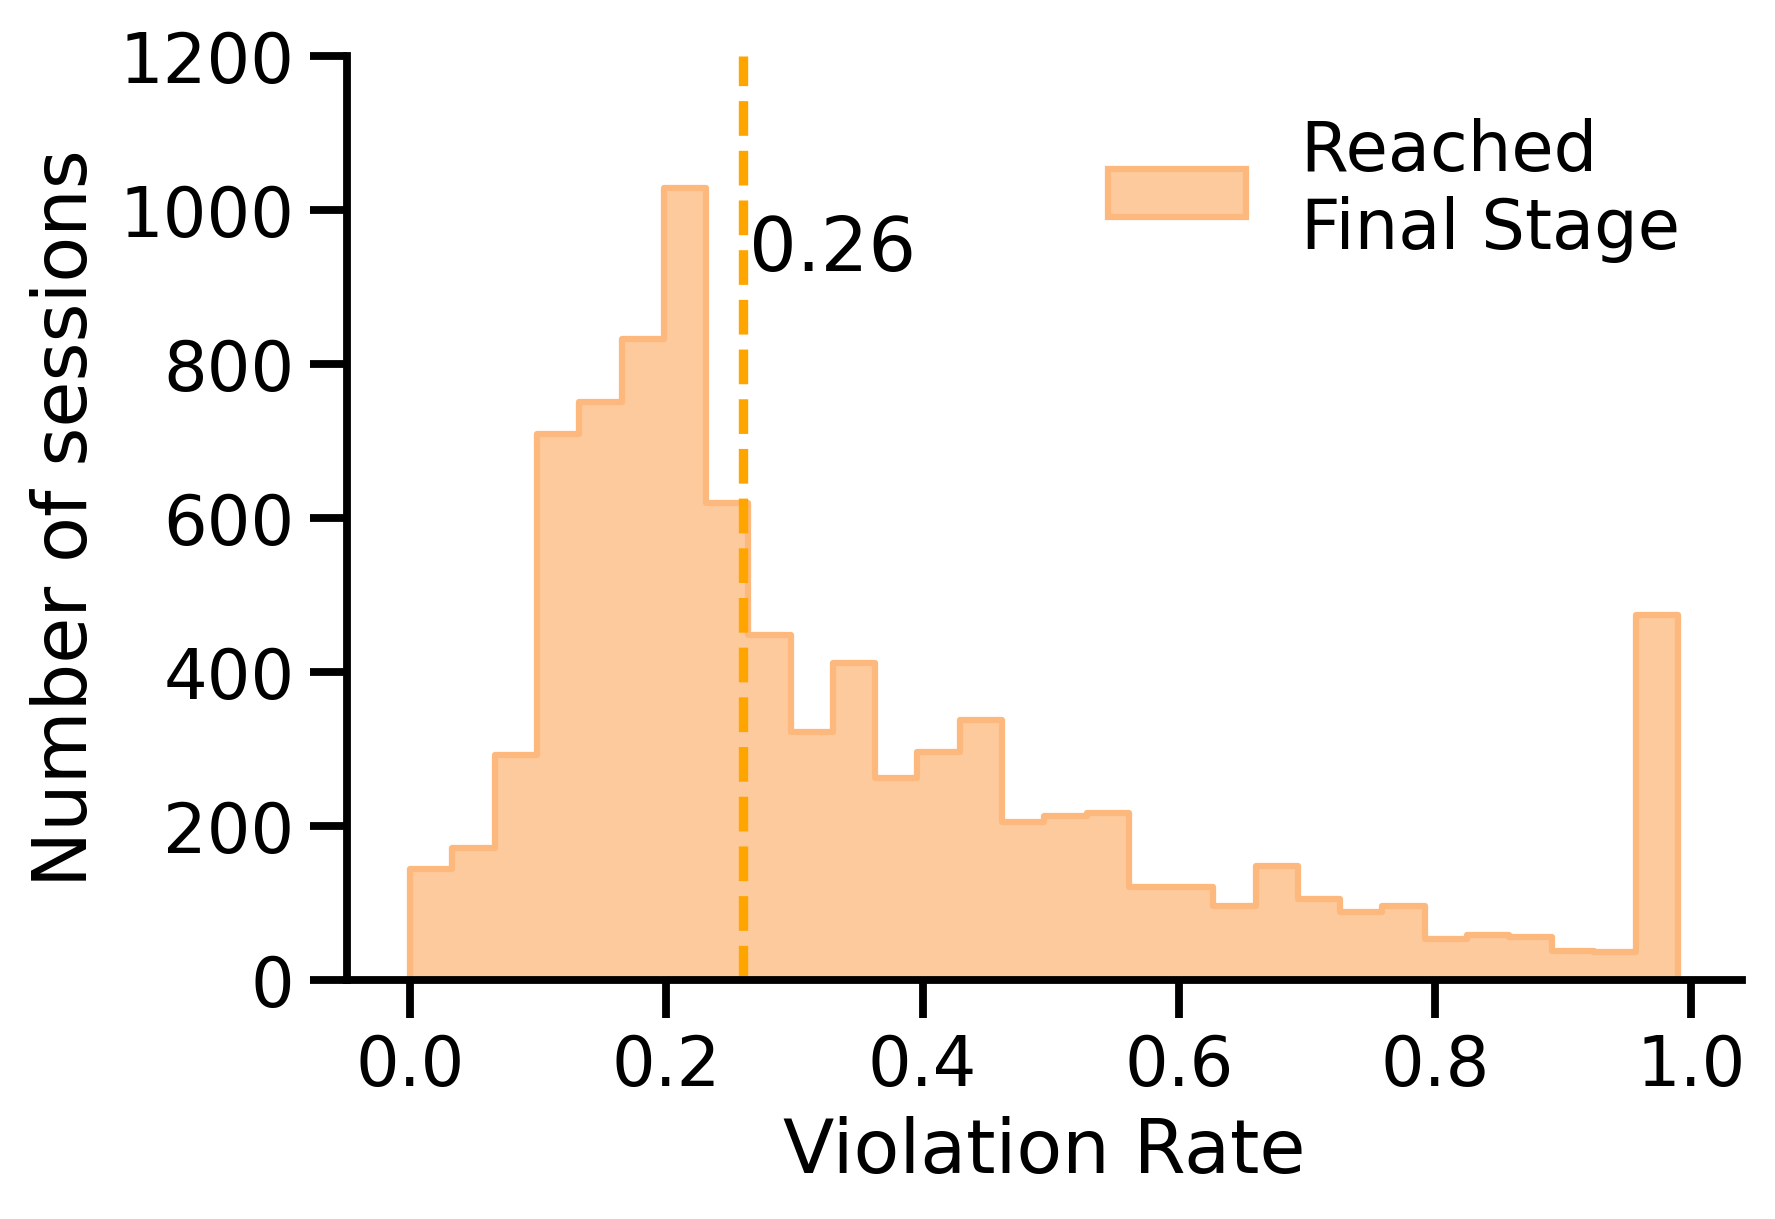

In [175]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df.query("not_sound_rule == False"),
    x="percent_violations",
    element="step",
    color=orange_pal[0],
    bins=30,
)

ax.legend(["Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

median = cpoke_df.query("not_sound_rule == False")["percent_violations"].median()
ax.axvline(median, color="orange", linestyle="--")
ax.text(
    median + 0.07,
    900,
    f"{median:.2f}",
    ha="center",
    va="bottom",
    color="k",
)
sns.despine()

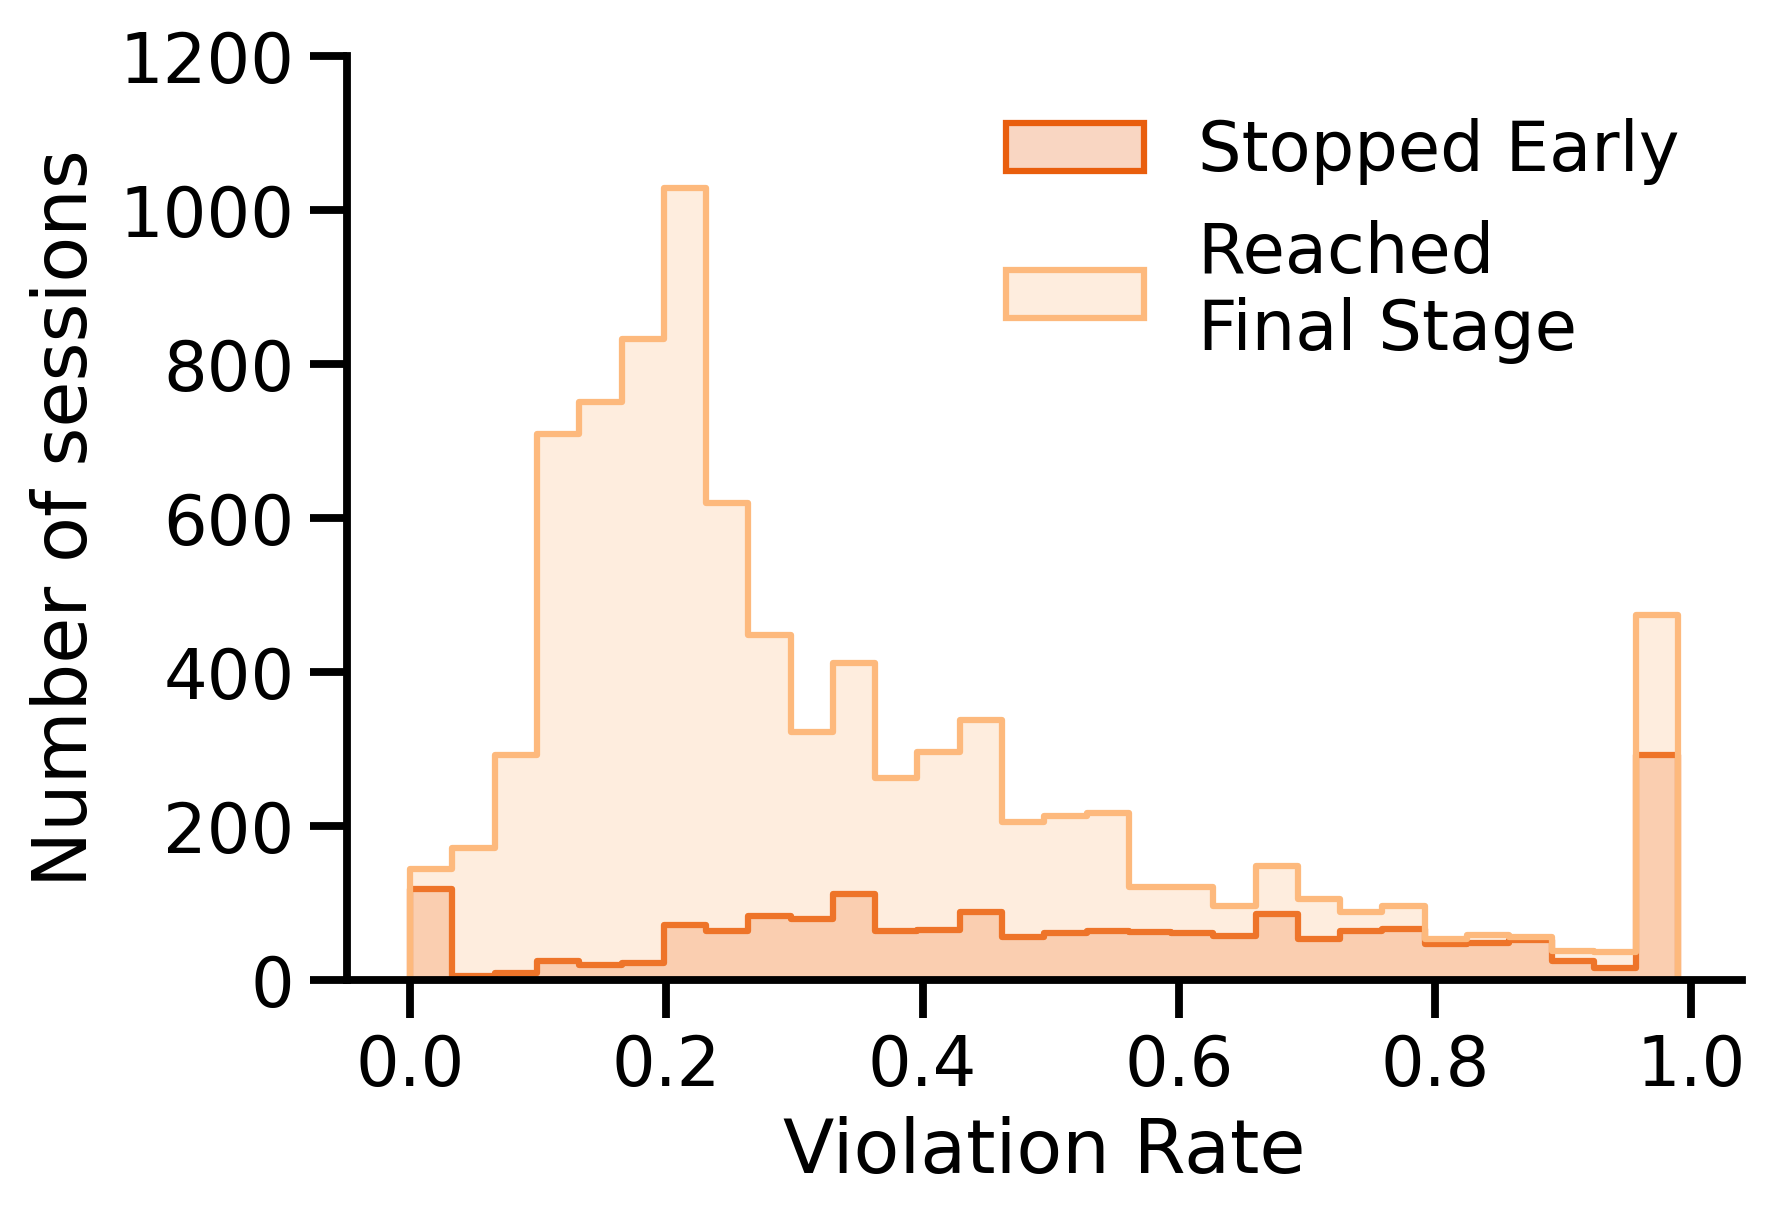

In [176]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette="Oranges",
    bins=30,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

sns.despine()

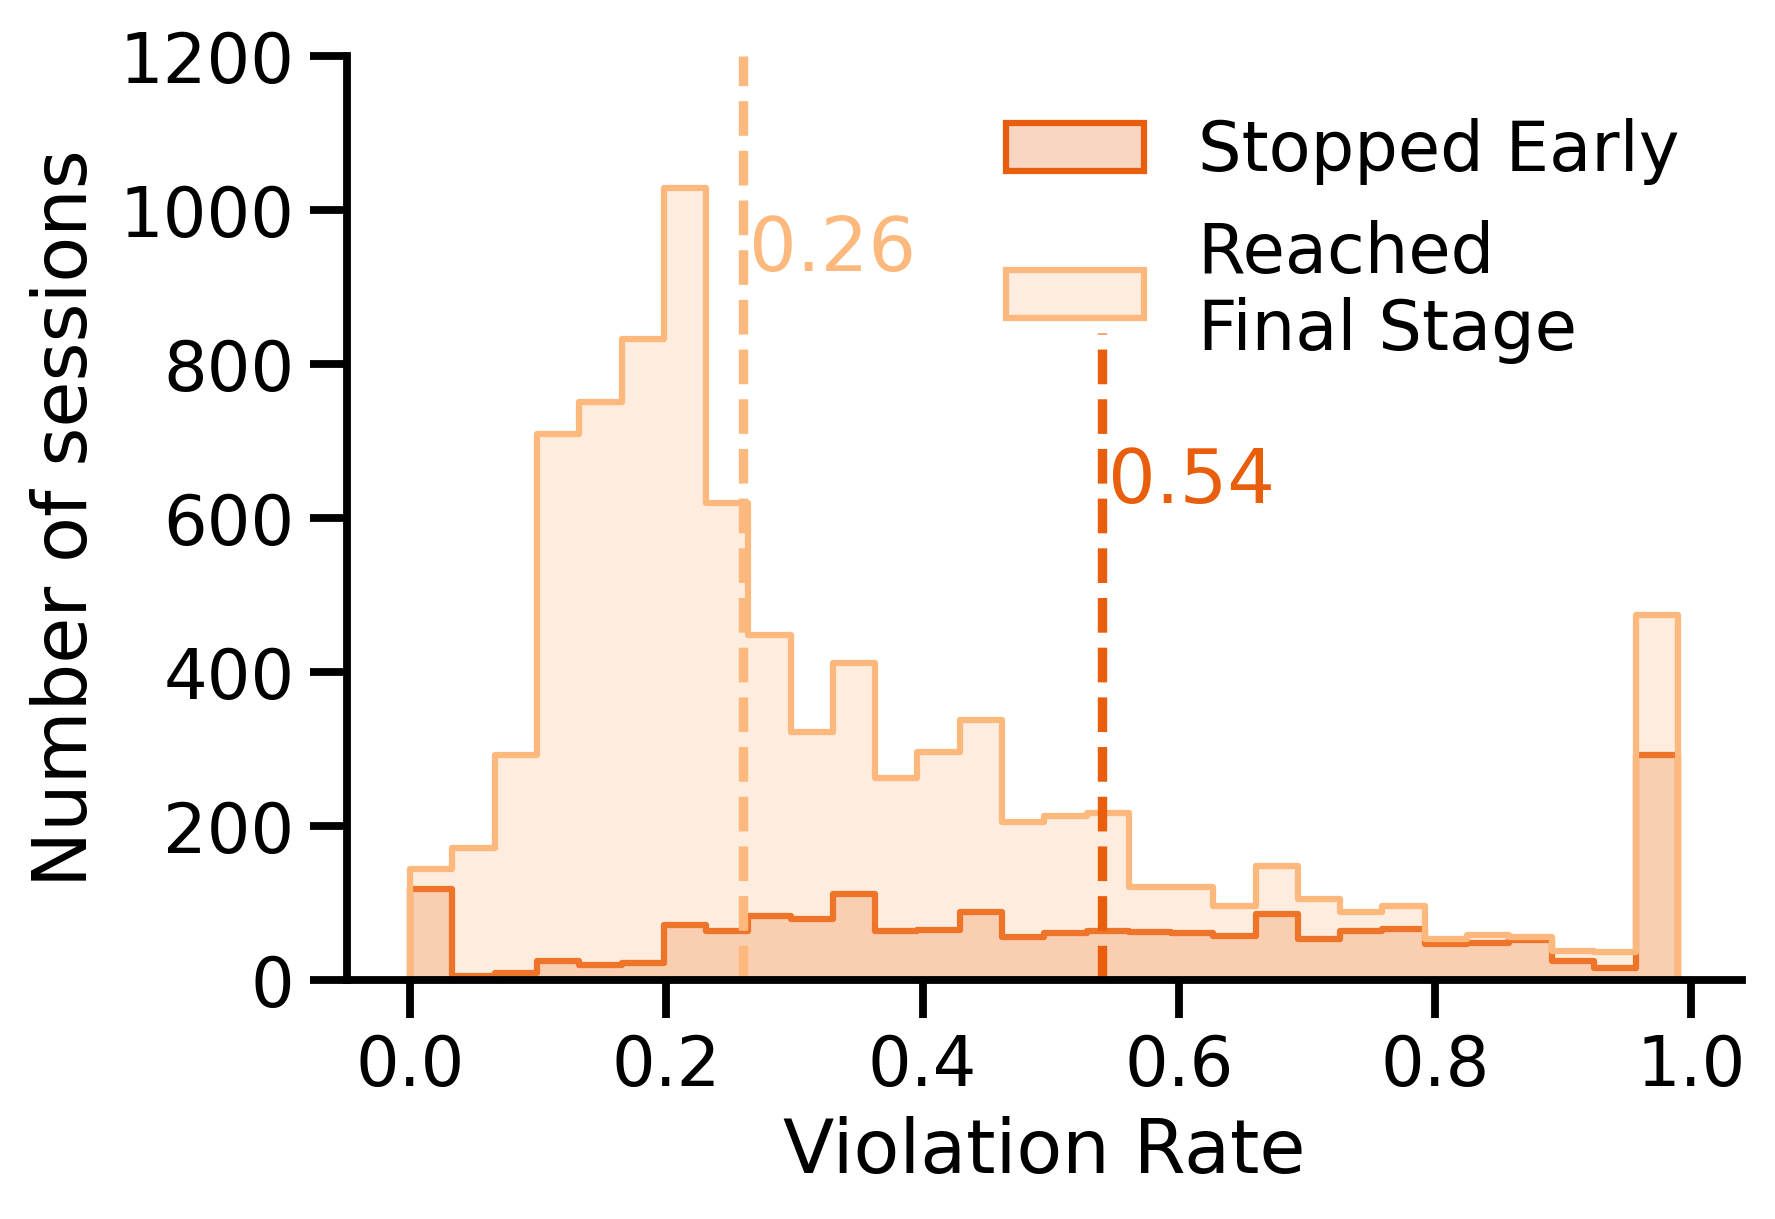

In [177]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette="Oranges",
    bins=30,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in cpoke_df.groupby("not_sound_rule"):
    median = sub_df["percent_violations"].median()
    if condition:
        ymax = 0.7
        ytext = 600
    else:
        ymax = 1
        ytext = 900
    ax.axvline(median, ymax=ymax, color=orange_pal[condition], linestyle="--")
    ax.text(
        median + 0.07,
        ytext,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

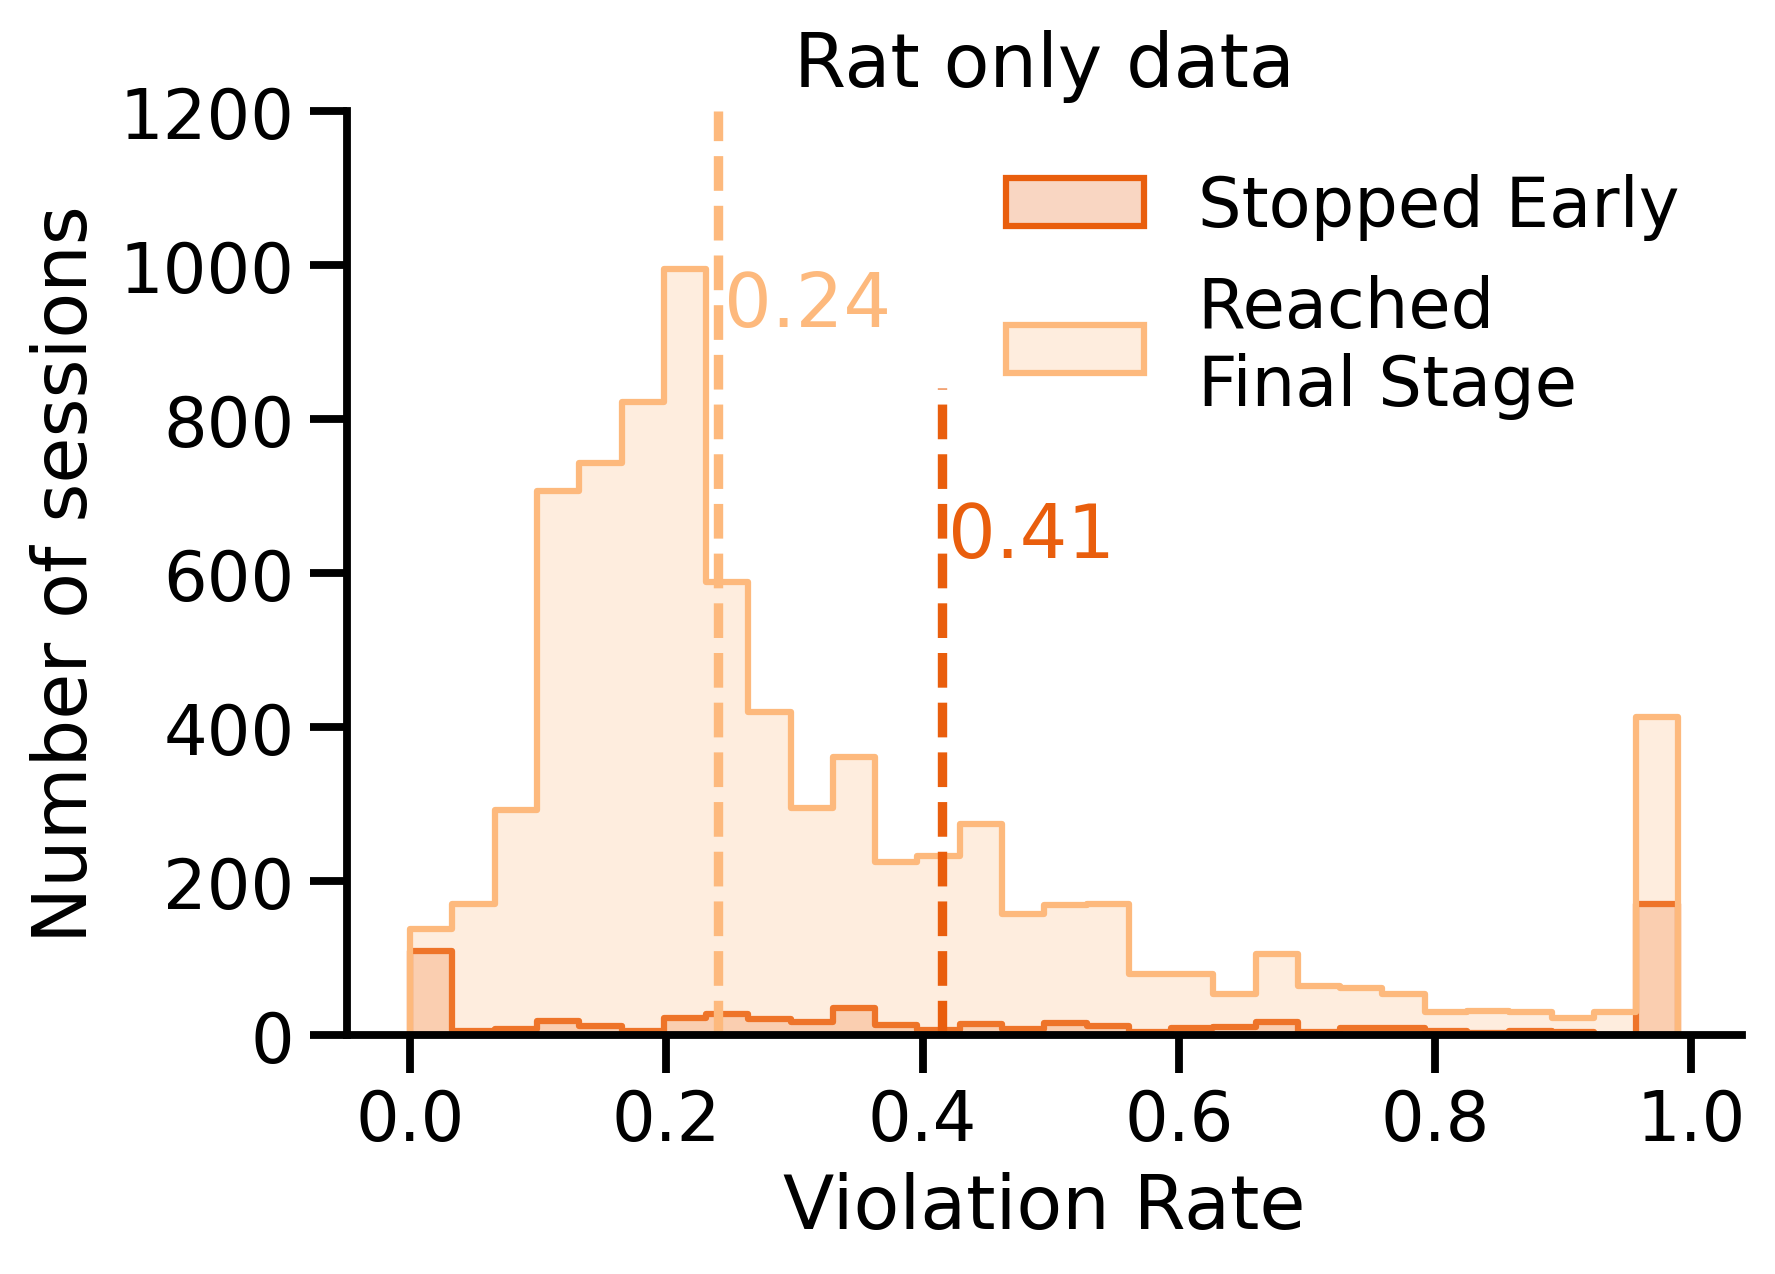

In [178]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df.query("species == 'rat'"),
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette="Oranges",
    bins=30,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
    title="Rat only data",
)

for condition, sub_df in cpoke_df.query("species == 'rat'").groupby("not_sound_rule"):
    median = sub_df["percent_violations"].median()
    if condition:
        ymax = 0.7
        ytext = 600
    else:
        ymax = 1
        ytext = 900
    ax.axvline(median, ymax=ymax, color=orange_pal[condition], linestyle="--")
    ax.text(
        median + 0.07,
        ytext,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

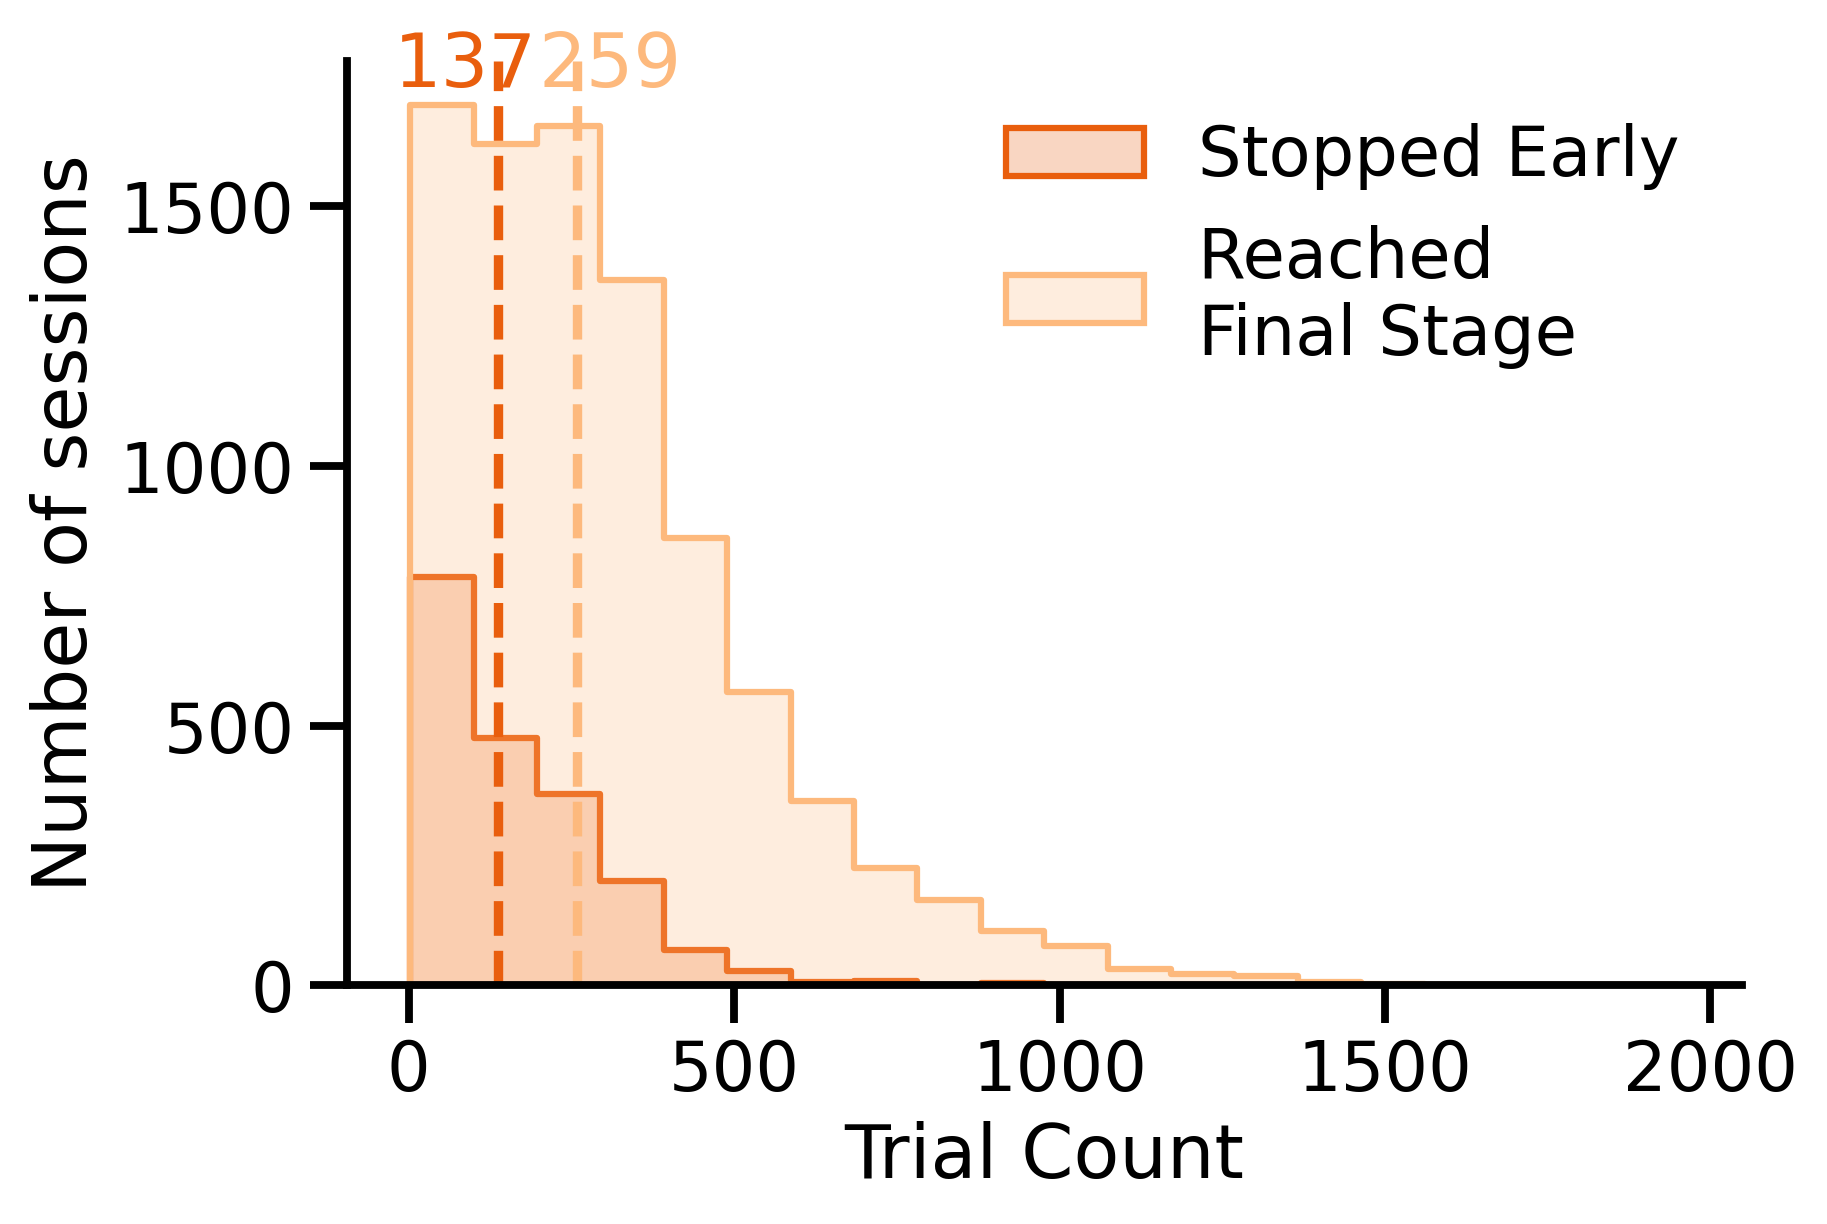

In [199]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df,
    x="n_done_trials",
    element="step",
    hue="not_sound_rule",
    palette="Oranges",
    bins=20,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    # ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Trial Count",
)

for condition, sub_df in cpoke_df.groupby("not_sound_rule"):
    median = sub_df["n_done_trials"].median()
    if condition:
        xloc = median - 50
    else:
        xloc = median + 50
    ax.axvline(median, color=orange_pal[condition], linestyle="--")
    ax.text(
        xloc,
        1700,
        f"{median:.0f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

# 3 Determining Training Success

Now lets see how many animals actually got the rule in the never stage.

Determining training:
- rolling window of hit rate ~ 2 weeks, cross 70% threshold- see raw data & assess

Final plots
- violation rate histogram for animals that made it to the stage and do/don't train
- bar plot with number of animals trained + yeild in stages to drive home differences

In [201]:
def compute_rolling_mean(df, column, window_size):
    """
    Function to compute the rolling mean of a column for each ratname
    across sessions
    """
    grouped_over_sessions = (
        df.groupby(["ratname", "sessiondate"])[column].mean().reset_index()
    )
    rolling_mean = (
        grouped_over_sessions.groupby("ratname")
        .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())
        .reset_index()
    )

    rolling_mean.rename(columns={column: f"rolling_mean_{column}"}, inplace=True)
    rolling_mean["window_size"] = window_size

    return pd.merge(
        grouped_over_sessions,
        rolling_mean.drop(columns=["ratname"]),  # already in grouped df
        left_index=True,
        right_on="level_1",  # index of grouped df
        how="left",
    ).drop(columns=["level_1"])

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_55805/1142083431.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())


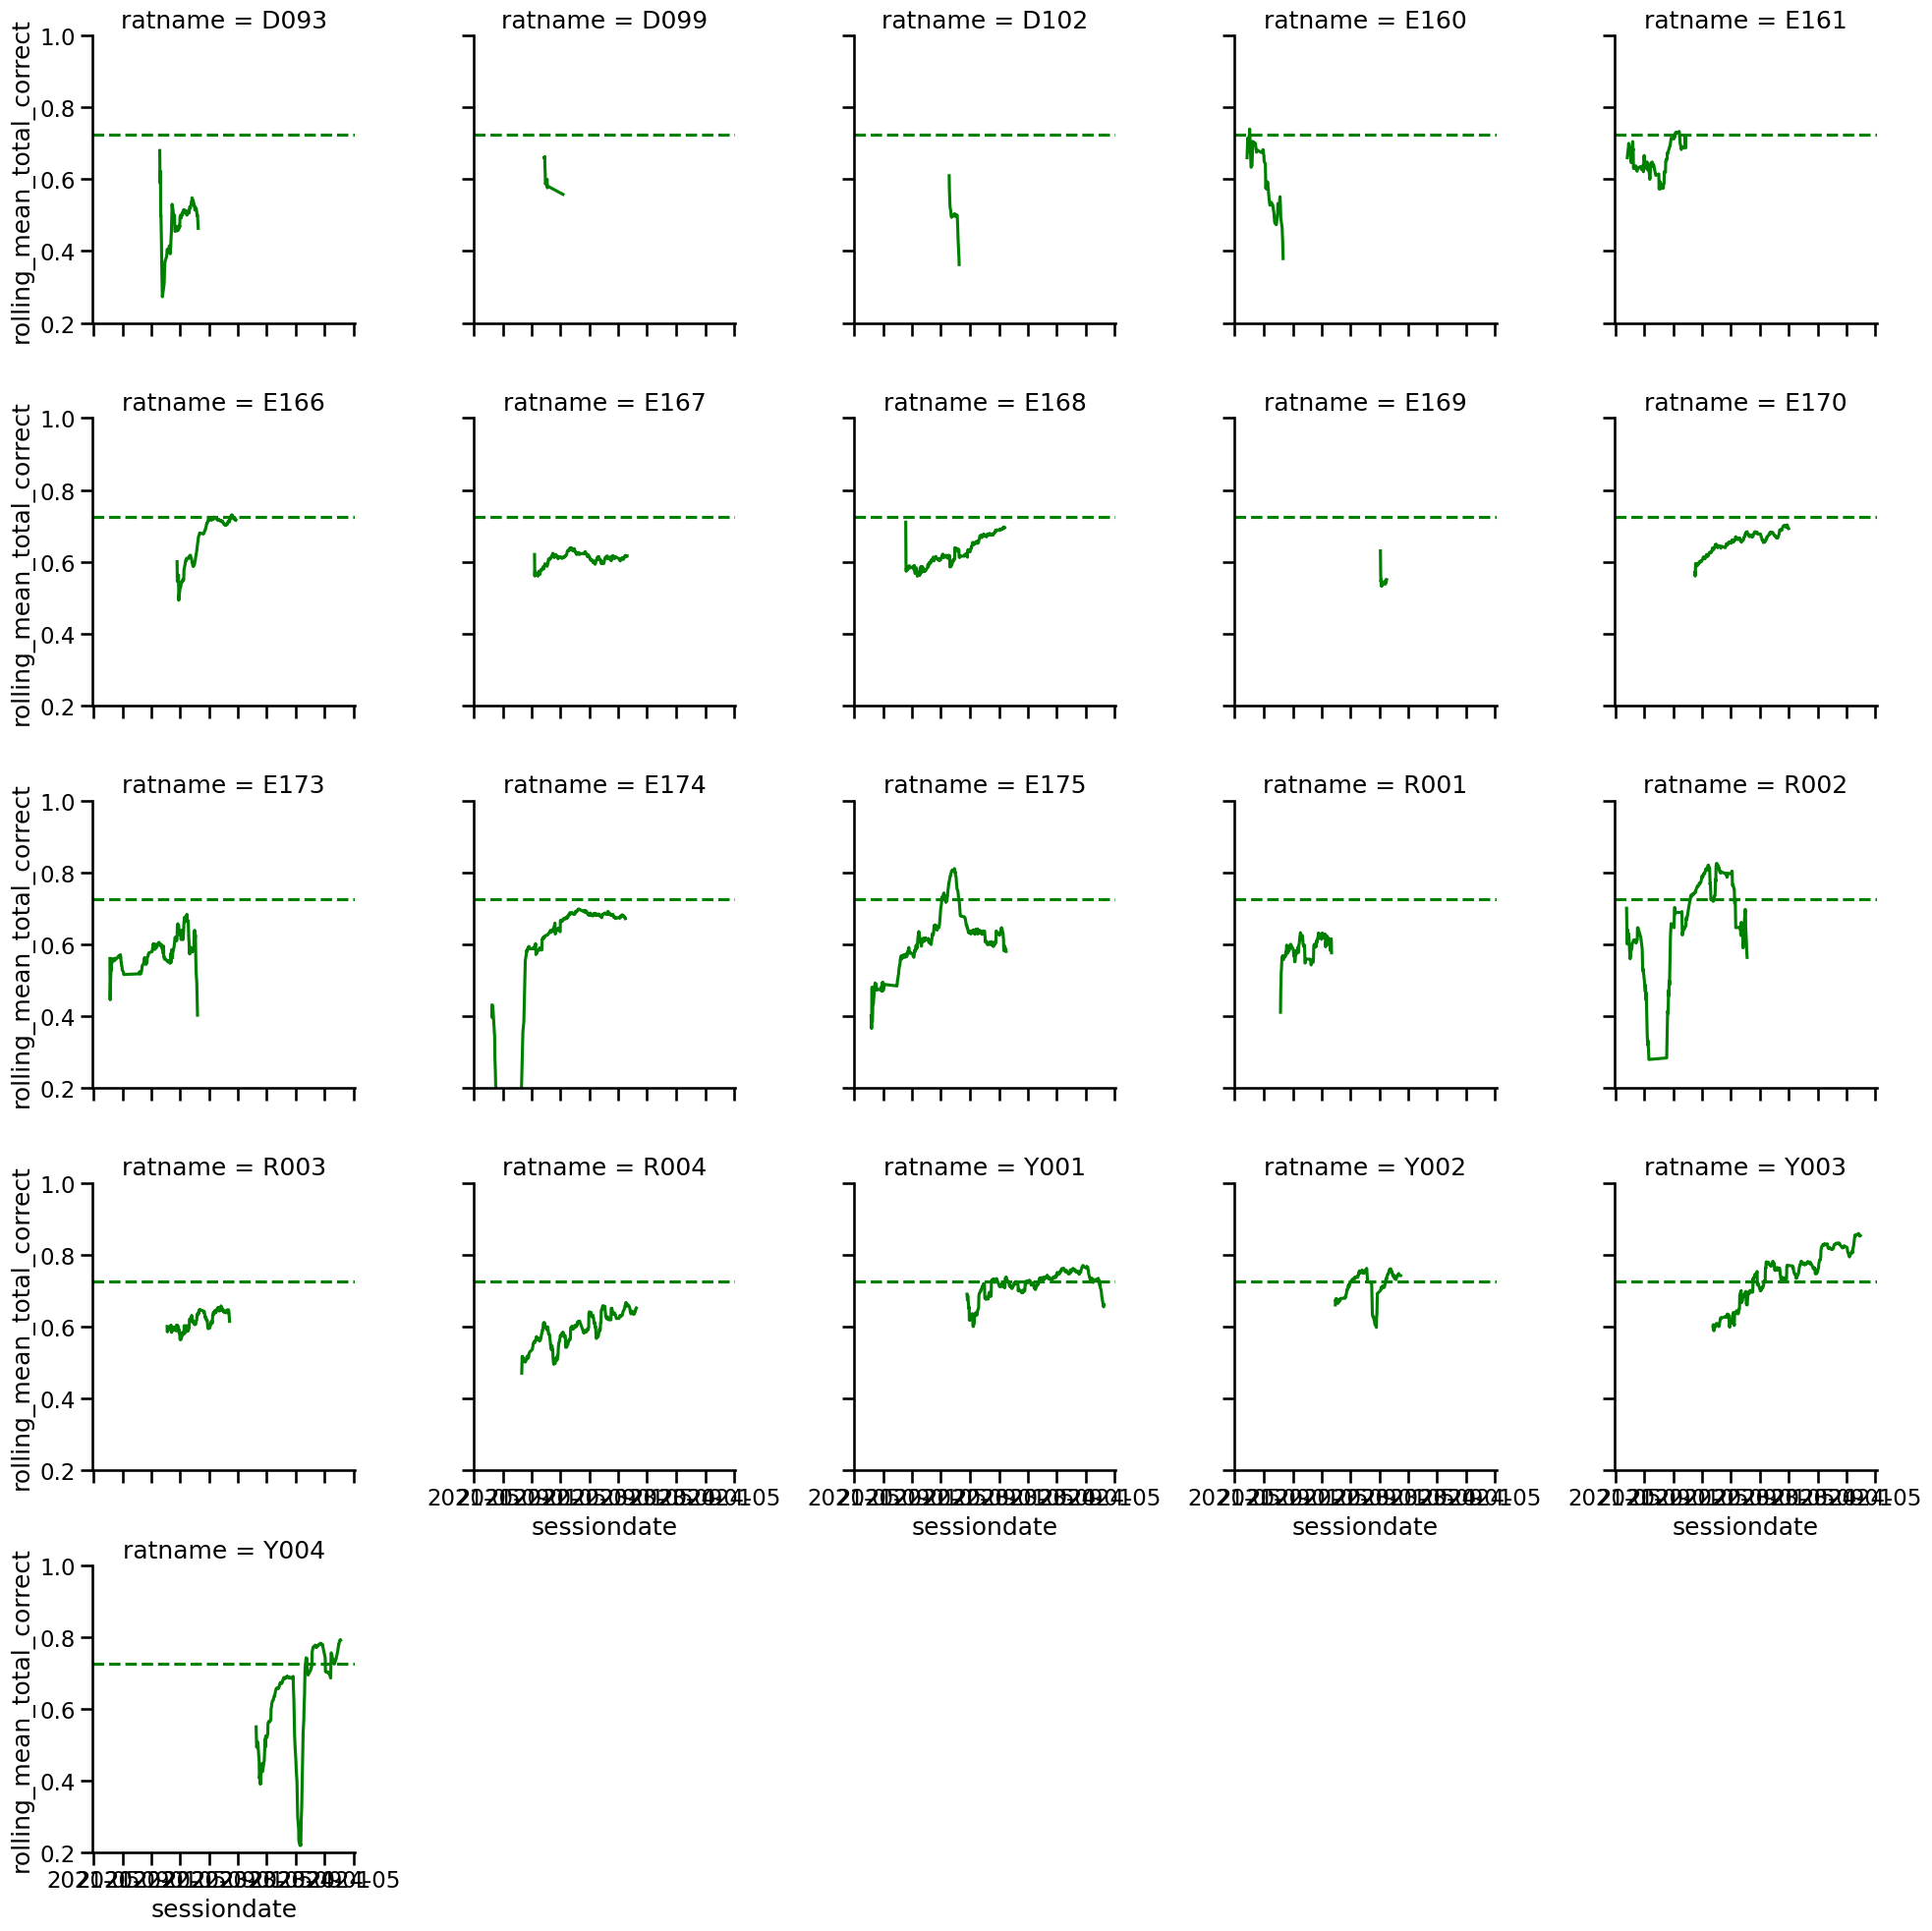

In [206]:
hit_rolling_mean = compute_rolling_mean(
    cpoke_df.query("stage_name == 'never'"), "total_correct", window_size=21
)

g = sns.FacetGrid(
    data=hit_rolling_mean, col="ratname", col_wrap=5, height=4, ylim=(0.2, None)
)
g.map(sns.lineplot, "sessiondate", "rolling_mean_total_correct", color="green")
g.map(plt.axhline, y=0.725, color="green", linestyle="--")

In [275]:
trained_animals = [
    "R002",
    "Y001",
    "Y002",
    "Y003",
    "Y004",
]  # just doing this by eye- not going to over-complicate things
stage_counts.loc[len(stage_counts)] = [6, len(trained_animals), "Trained"]

cpoke_df["trained"] = cpoke_df.ratname.isin(trained_animals)

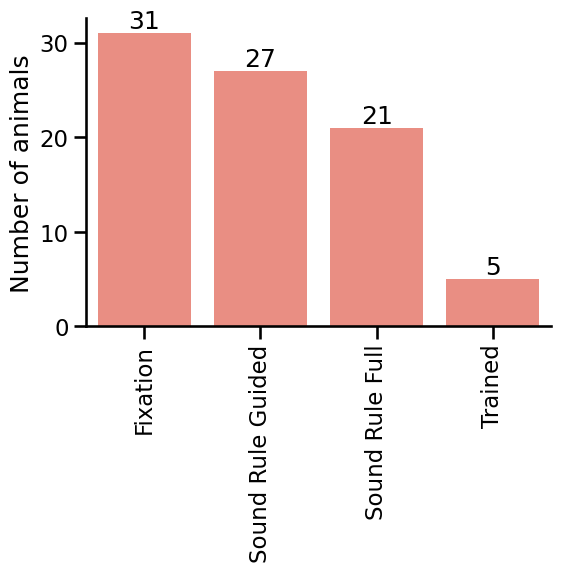

In [276]:
# fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=stage_counts.query("stage_number > 1 and stage_number !=3"),
    x="stage_name",
    y="ratname",
    ax=ax,
    color="salmon",
)

# put counts on top of bars
for i, row in (
    stage_counts.query("stage_number > 1 and stage_number !=3").reset_index().iterrows()
):
    ax.text(
        i,
        row["ratname"],
        row["ratname"],
        ha="center",
        va="bottom",
        color="black",
    )

ax.set(
    xlabel="",
    ylabel="Number of animals",
)
ax.tick_params(axis="x", rotation=90)

sns.despine()

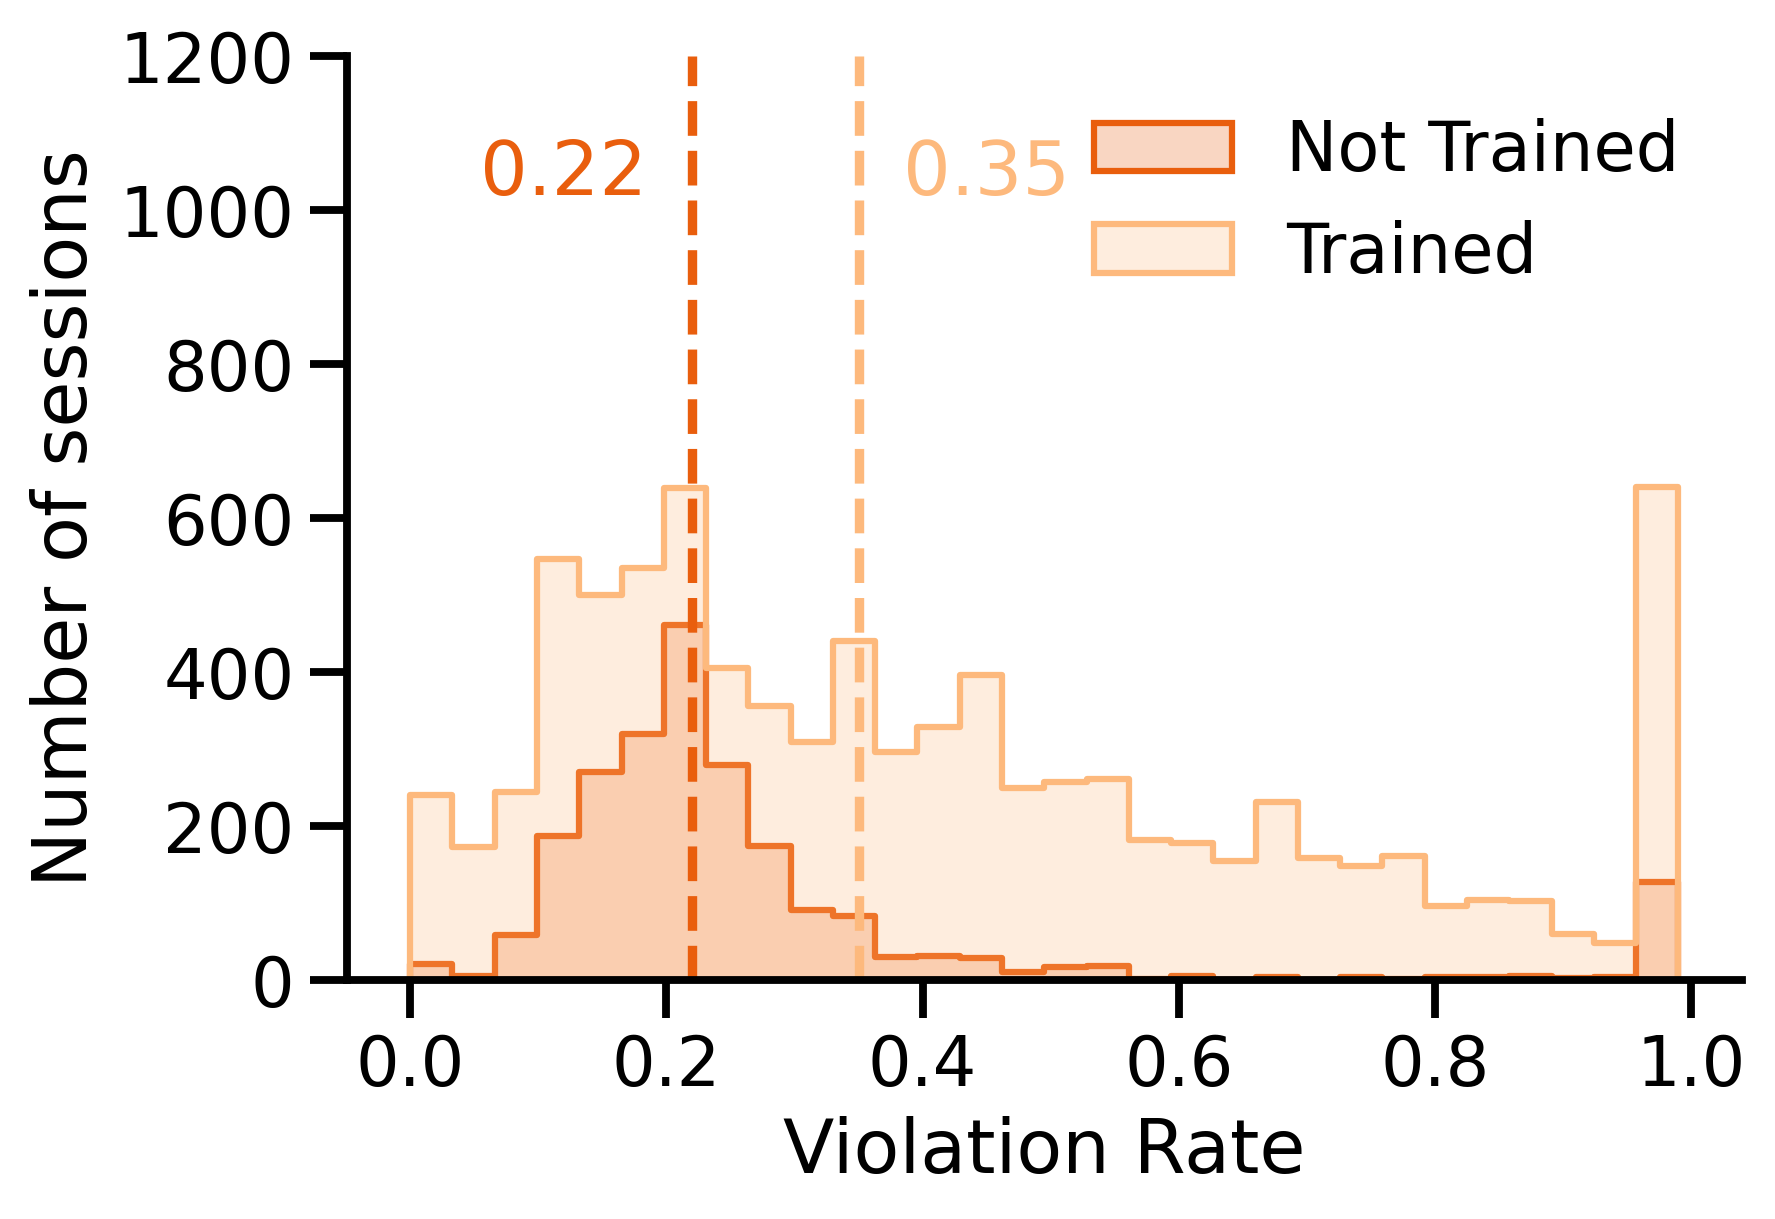

In [301]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)

sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=[False, True],
    palette="Oranges",
    bins=30,
)
ax.legend(["Not Trained", "Trained"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in cpoke_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=orange_pal[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        1000,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

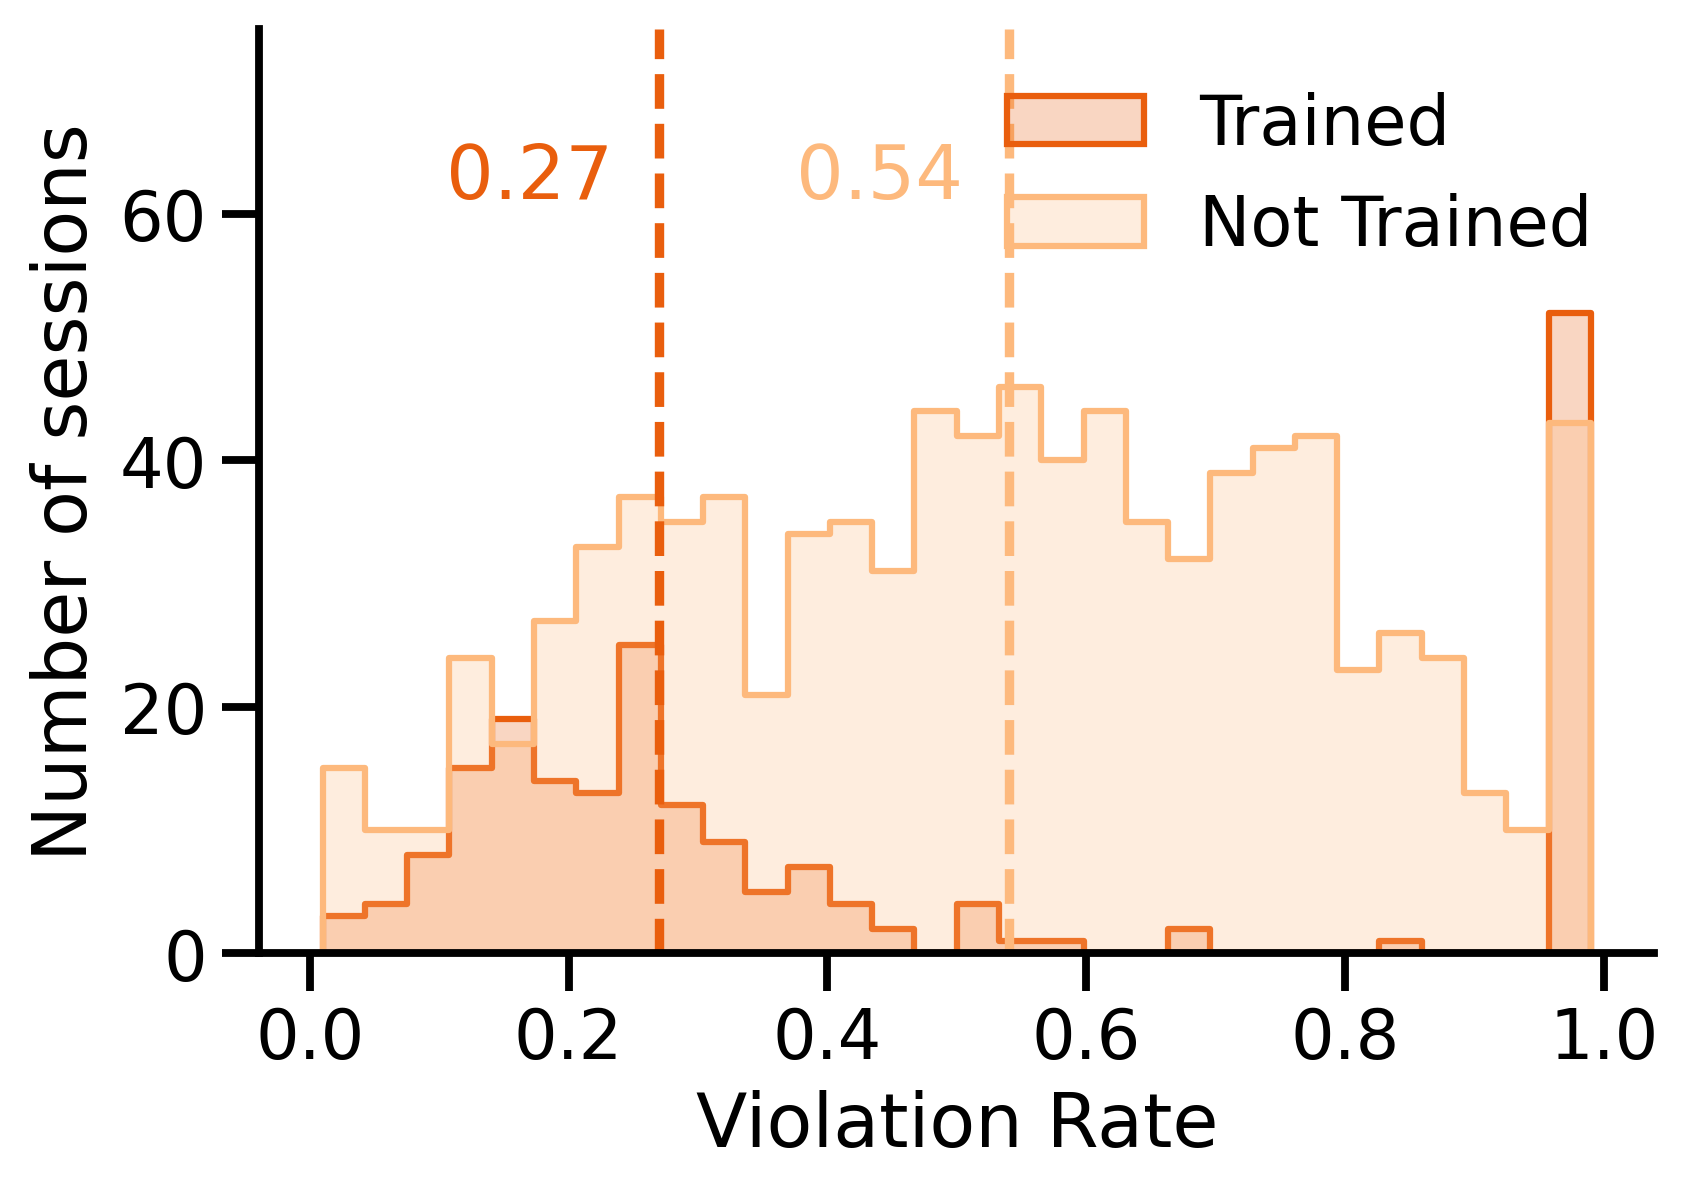

In [335]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)

plot_df = cpoke_df.query(
    "not_never == False and stage_name =='gnp' and percent_violations != 0"
)  # lets look at animals that did reach the final stage
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=[False, True],
    palette="Oranges",
    bins=30,
)
ax.legend(["Trained", "Not Trained"], frameon=False, loc="upper right")
ax.set(
    ylim=(0, 75),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in plot_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=orange_pal[condition], linestyle="--")
    ax.text(
        median - 0.1,
        60,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

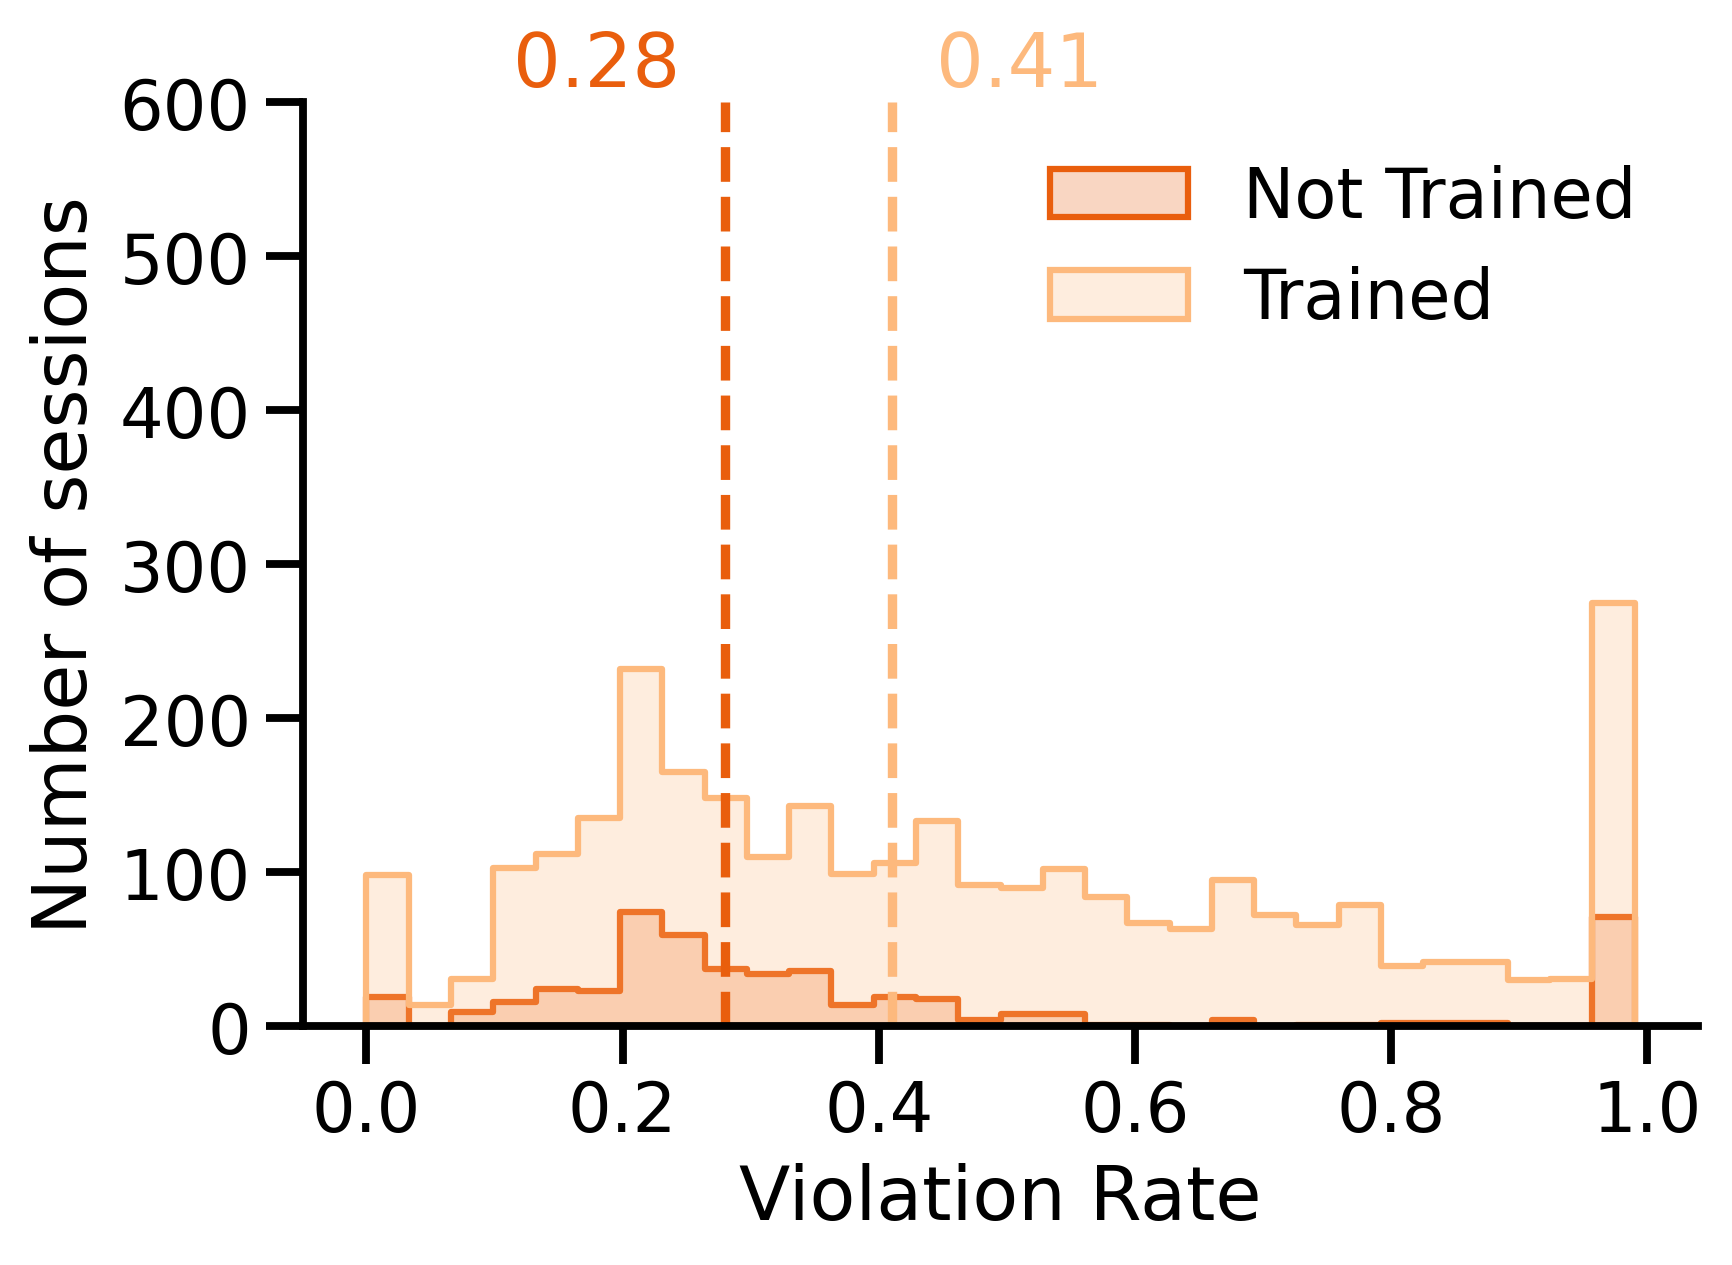

In [336]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)

plot_df = cpoke_df.query(
    "not_never == False and stage_name !='never'"
)  # lets look at animals that did reach the final stage
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=[False, True],
    palette="Oranges",
    bins=30,
)
ax.legend(["Not Trained", "Trained"], frameon=False)
ax.set(
    ylim=(0, 600),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in plot_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=orange_pal[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        600,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

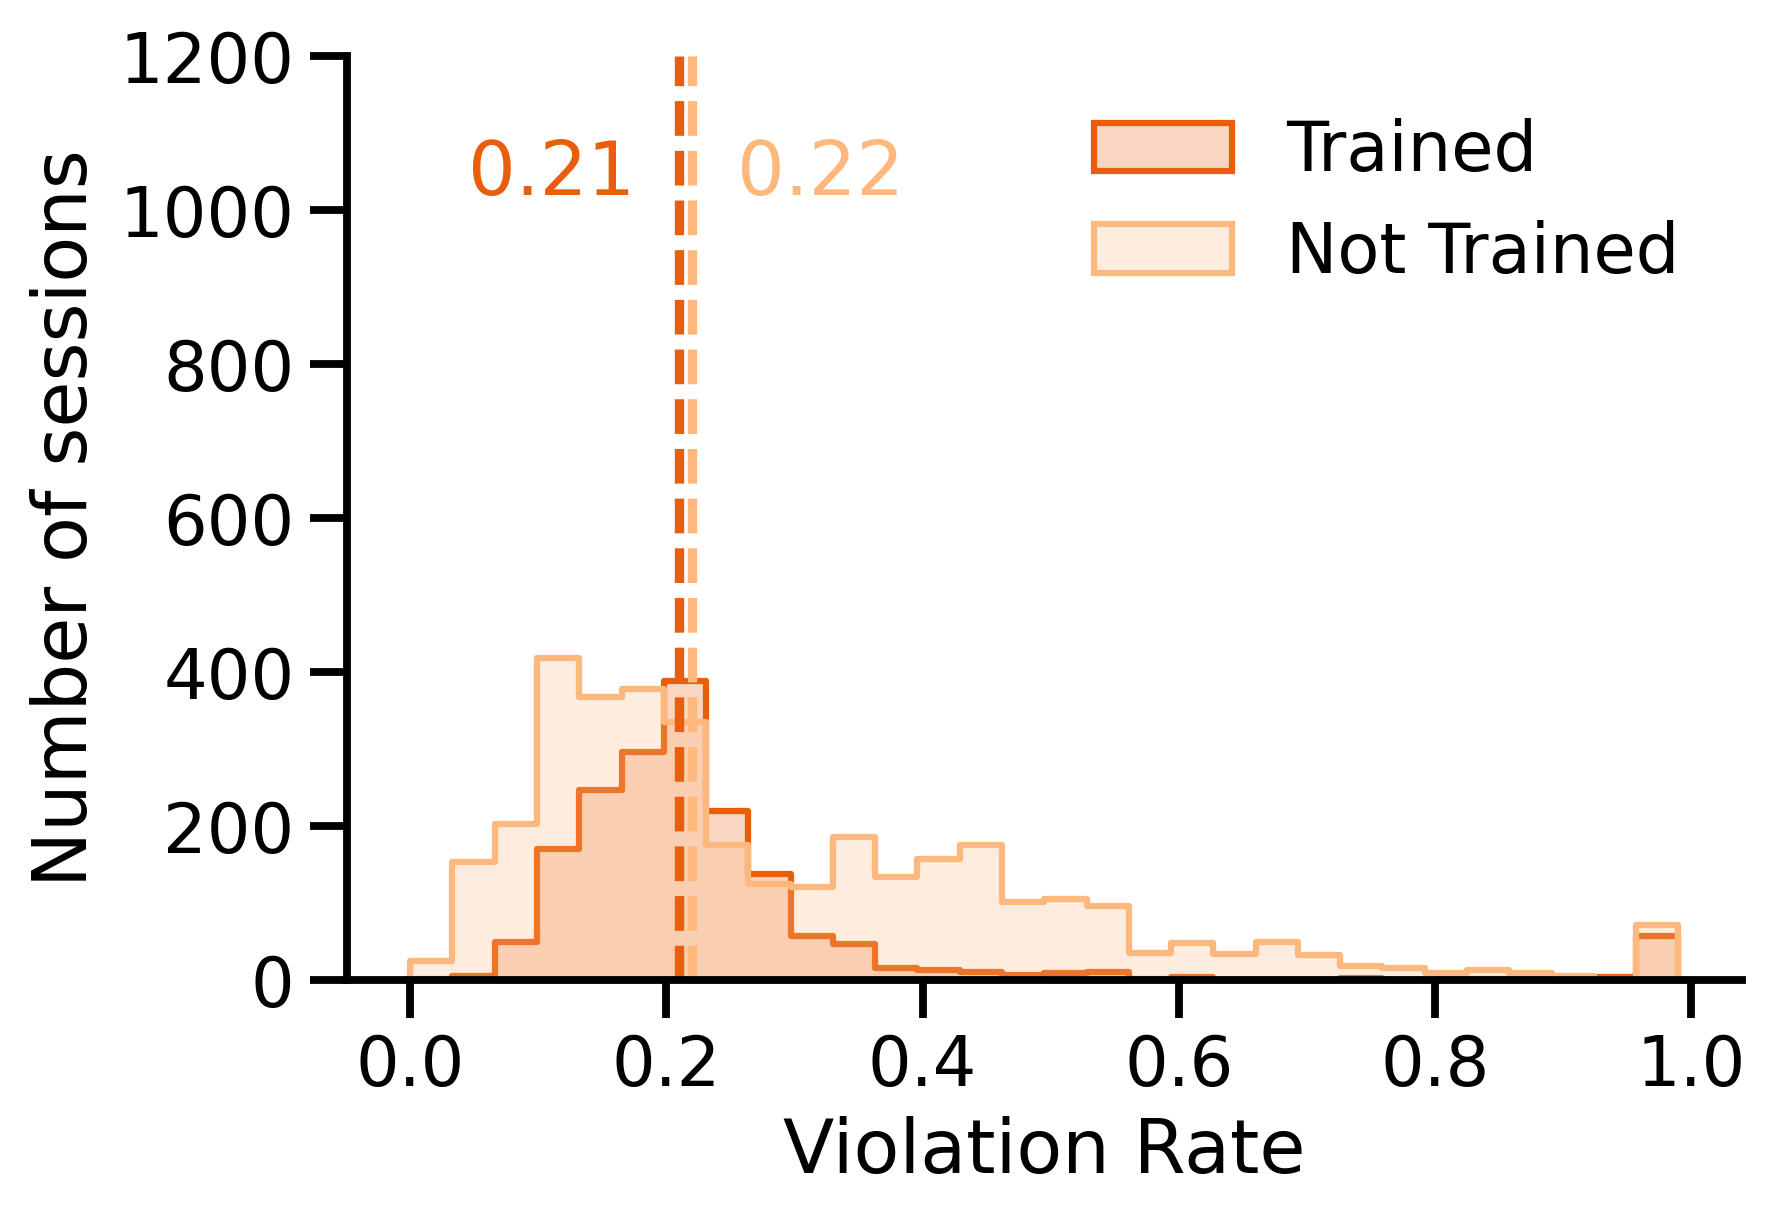

In [338]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)

plot_df = cpoke_df.query("not_never == False and stage_name == 'never'")
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=[False, True],
    palette="Oranges",
    bins=30,
)
ax.legend(["Trained", "Not Trained"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in plot_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=orange_pal[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        1000,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=orange_pal[condition],
    )
sns.despine()

<Axes: xlabel='percent_violations', ylabel='total_correct'>

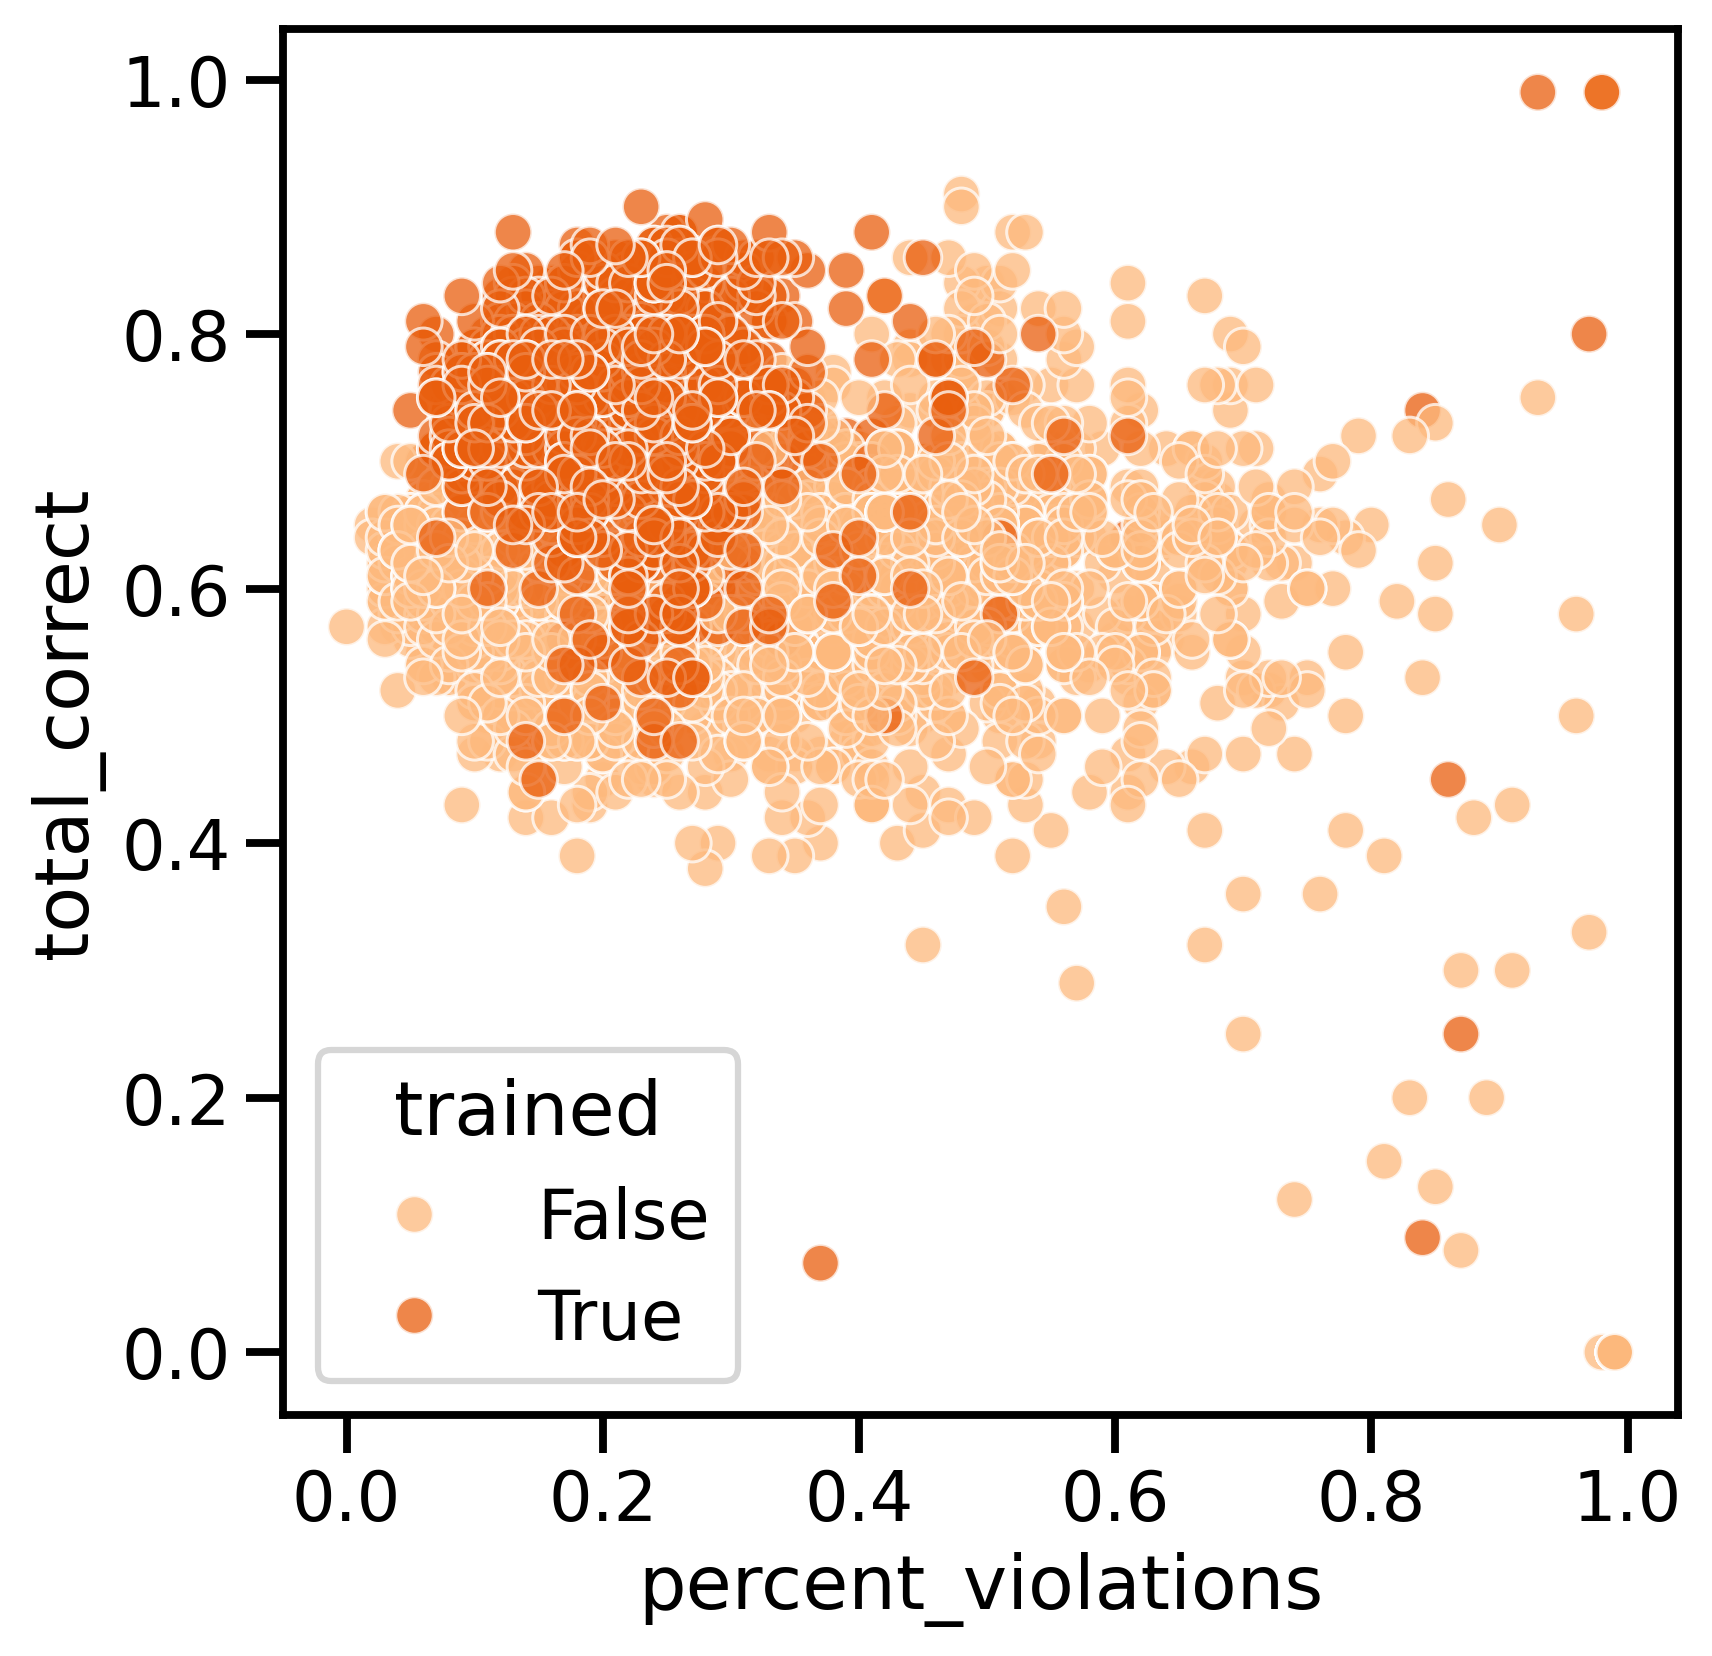

In [305]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(
    data=cpoke_df.query("stage_name == 'never' and n_done_trials > 50"),
    x="percent_violations",
    y="total_correct",
    hue="trained",
    alpha=0.75,
    palette="Oranges",
    hue_order=[False, True],
)

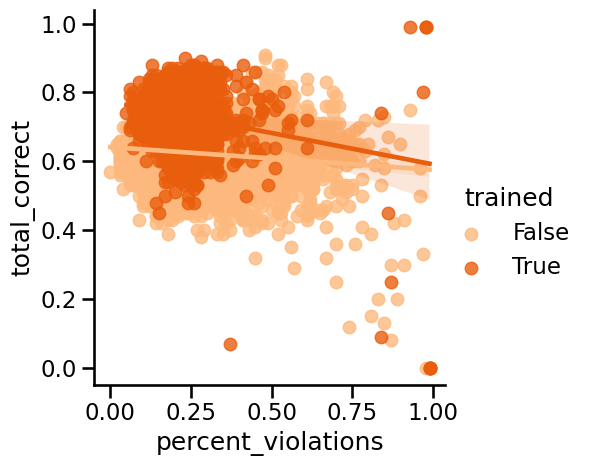

In [306]:
sns.lmplot(
    data=cpoke_df.query("stage_name == 'never' and n_done_trials > 50"),
    x="percent_violations",
    y="total_correct",
    hue="trained",
    hue_order=[False, True],
    palette="Oranges",
)

In [307]:
session_agg_perf = (
    cpoke_df.query("stage_name == 'never' and n_done_trials > 50")
    .groupby("ratname")
    .agg({"percent_violations": "mean", "total_correct": "mean", "trained": "first"})
    .reset_index()
)

In [308]:
session_agg_perf.head()

,ratname,percent_violations,total_correct,trained
0,D093,0.485403,0.503871,False
1,D099,0.504444,0.558889,False
2,D102,0.363421,0.424211,False
3,E160,0.358649,0.590541,False
4,E161,0.337698,0.680935,False


[(0.3, 0.9),
 (0.0, 0.7),
 Text(0.5, 0, 'Violation Rate'),
 Text(0, 0.5, 'Hit Rate')]

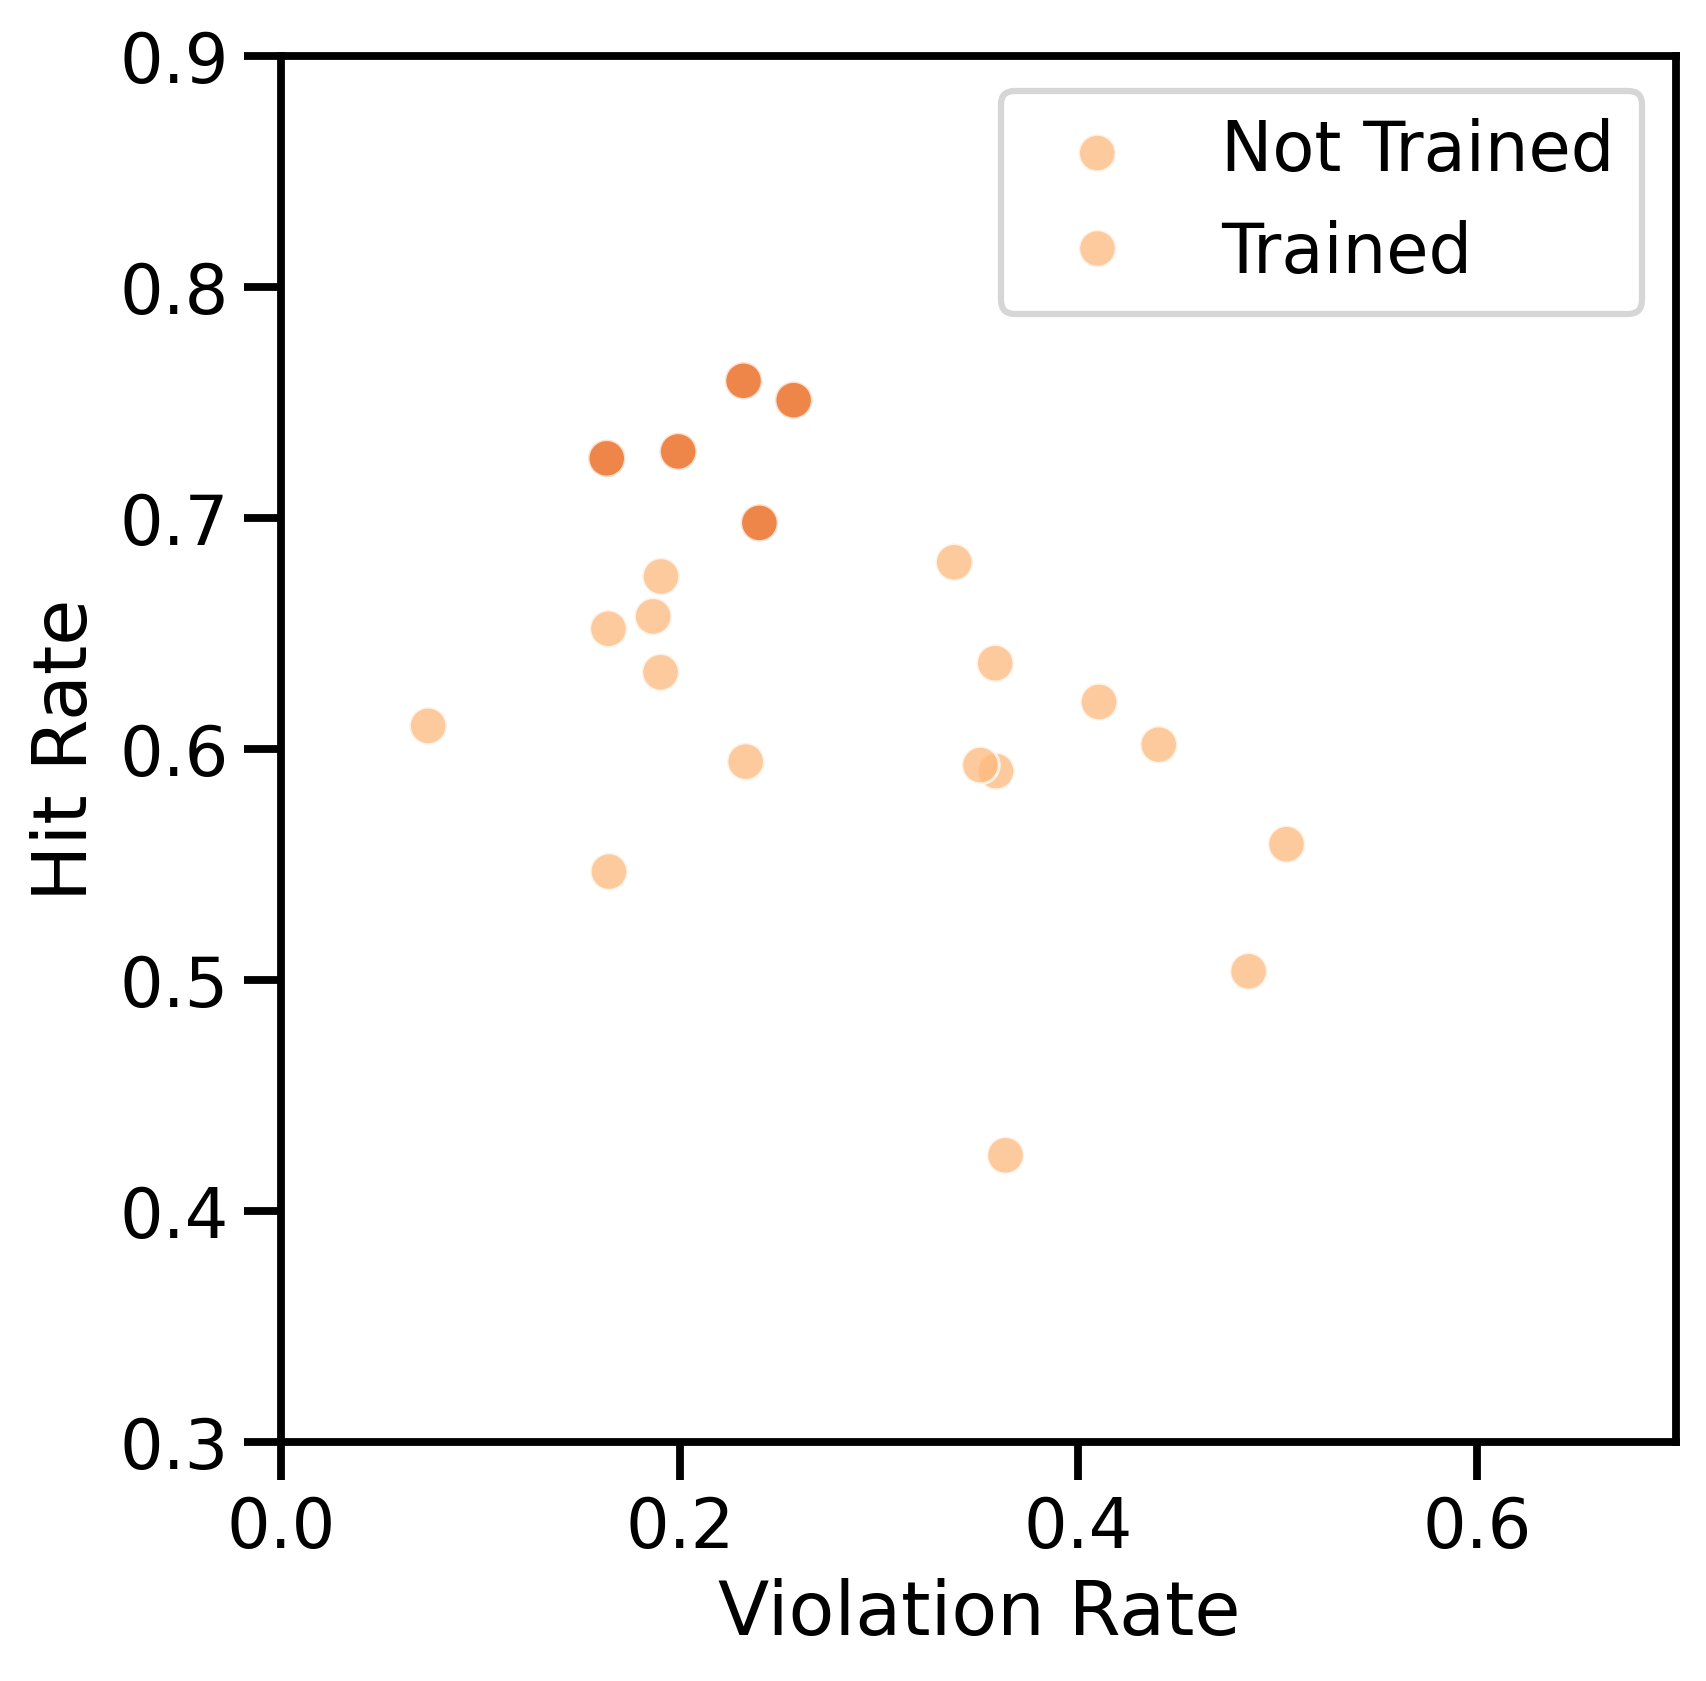

In [320]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(
    data=session_agg_perf,
    x="percent_violations",
    y="total_correct",
    hue="trained",
    alpha=0.75,
    palette="Oranges",
    hue_order=[False, True],
)

ax.legend(
    ["Not Trained", "Trained"],
)

ax.set(ylim=(0.3, 0.9), xlim=(0, 0.7), xlabel="Violation Rate", ylabel="Hit Rate")

# # label by ratname
# for i, row in session_agg_perf.iterrows():
#     ax.text(
#         row["percent_violations"],
#         row["total_correct"],
#         row["ratname"],
#         ha="center",
#         va="bottom",
#         color="black",
#     )

In [295]:
def univariate_linear_regression(df, x, y, print_results=True):
    """
    Performs univariate linear regression on given data.

    params
    -------
    df: pd.DataFrame
        Dataframe containing the data.
    x: str
        Name of the feature to be used as predictor.
    y: str
        Name of the feature to be used as target.

    Returns:
    - results (RegressionResults): Fitted regression model results.
    """

    X = df[x].values.reshape(-1, 1)
    y = df[y].values.reshape(-1, 1)
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    if print_results:
        print(results.summary())

    return results


def plot_univariate_linear_regression(results, ax=None, **kwargs):
    """
    Plots the linear regression model and data points.

    Parameters:
    - results (RegressionResults): Fitted regression model results.
    - ax (matplotlib axis, optional): Axis on which to plot.
    - kwargs (dict): Additional settings for plot axis.

    Returns:
    - ax (matplotlib axis): Axis containing the plot.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    slope = results.params[1]
    intercept = results.params[0]

    # Get x and y data from the results
    x_data = results.model.exog[:, 1]
    y_data = results.model.endog

    # Determine the range for the line model
    x_line = np.linspace(min(x_data) * 0.5, max(x_data) * 1.5, 100)
    y_line = slope * x_line + intercept

    ax.scatter(x_data, y_data, color="black", label="Data")
    ax.plot(x_line, y_line, color="salmon", label="Regression Line")

    # Set axis limits, labels, title etc. based on kwargs
    ax.set(**kwargs)

    # Add text to upper right corner
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(xlim[1] * 0.75, ylim[1] * 0.75, f"$R^2$ = {results.rsquared_adj:.2f}")

    return ax

In [310]:
results = univariate_linear_regression(
    session_agg_perf, x="percent_violations", y="total_correct", print_results=True
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.308
Date:                Mon, 19 Aug 2024   Prob (F-statistic):             0.0327
Time:                        16:55:57   Log-Likelihood:                 25.660
No. Observations:                  21   AIC:                            -47.32
Df Residuals:                      19   BIC:                            -45.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7218      0.043     16.861      0.0

<Axes: title={'center': 'Hit Rate ~ Violation Rate'}, xlabel='Session Avg. Violation Rate', ylabel='Session Avg. Hit Rate'>

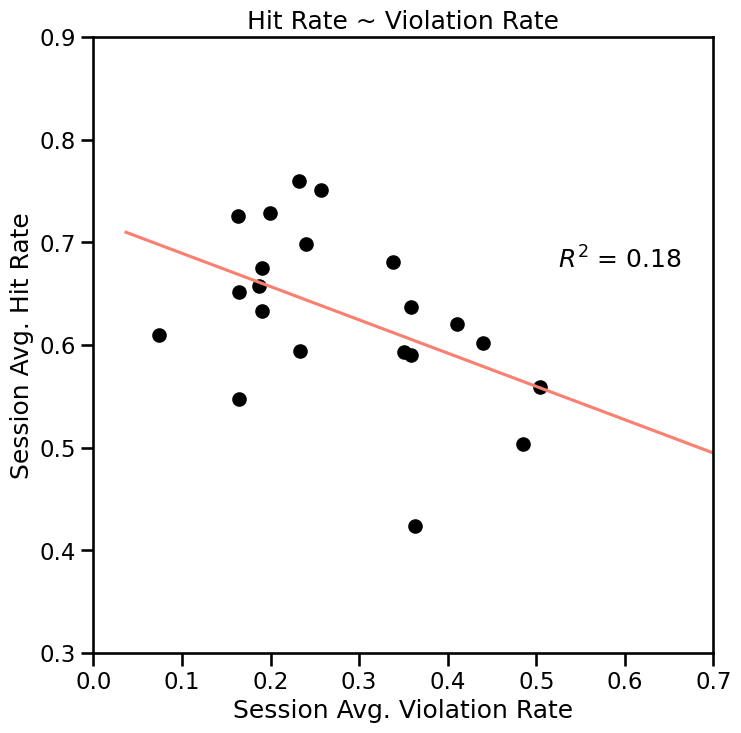

In [311]:
plot_univariate_linear_regression(
    results,
    xlabel="Session Avg. Violation Rate",
    ylabel="Session Avg. Hit Rate",
    title=f"Hit Rate ~ Violation Rate",
    ylim=(0.3, 0.9),
    xlim=(0, 0.7),
)